# Exploratory Data Analysis - Flicker8k, MSCOCO-Captions, and VizWiz-Captions
### Reza Akbarian Bafghi

In this notebook, first of all, we show the format of the dataset, and then, by using histograms, we depict different distributions in the dataset. We find unique different types of words in each dataset and depict overlaps between these datasets. Afterward, by using word maps of different types of words, we show which words are the most common words in the captions.  Next, we use sunburst diagrams to show distributions of 3-grams in all captions of these datasets. Further, by using Place365 categories, we show in which scenes images of these datasets are mostly taken. In the end, we use ImageNet categories to show how many objects in these datasets overlap with each other.

After exploring the data, we want to evaluate the performance of models implemented by our group members. In this section, we use the prediction files that are provided by them. So, we have these three cases:

    - Show and Tell: A Neural Image Caption Generator (Sabrina's model) - It is trained on Flicker8k
    - Show, Attend and Tell: Neural Image Caption Generation with Visual Attention (Nidhin's model) - It is trained on MSCOCO-Captions

Then, we calculate the BLUE score for each of them. Sabrina split Flicker8k dataset into train, val, and test dataset. So, we evaluate models on selected captions for test dataset. We also depict the distribution of captions generated by these two models.

Here, we provide brief summaries of three datasets that we explored:

    - The VizWiz-Captions consists of 39,181 images originating from people who are blind that are each paired with 5 captions.
    https://vizwiz.org/tasks-and-datasets/image-captioning/
    
    
    - The MSCOCO-Caption contains human generated captions for images contained in the Microsoft Common Objects in COntext (COCO) dataset. Each image has 5 captions.
    https://cocodataset.org/#home
    
    
    - The Flicker8k consists of 8,000 images that are each paired with five different captions.
    https://www.kaggle.com/jainamshah17/flicker8k-image-captioning
    


### Exploratory Data Analysis

##### Import Libraries

In [90]:
import json
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import argparse
from PIL import Image
import collections
import numpy as np
import os
import re
import string
import sys
import pickle

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles
from functools import partial


#If error occurs about the nltk package, try to uncomment the following lines.
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

#### Dataset Format

VizWiz-Captions and MSCOCO-Captions follow similar structure. 

    images = [image]
    image = {
        "file_name": "VizWiz_train_00023410.jpg",
        "id": 23410
        "text_detected": true
    }
    annotations = [annotation]
    annotation = {
        "image_id": 23410,
        "id": 117050,
        "caption": "A plastic rewards card lying face down on the floor."
        "is_rejected": false,
        "is_precanned": false,
        "text_detected": true
    }

We just use "caption" of them to do EDA.

Flicker8k has another format. Every caption of this dataset is indicated like:

    image,caption
    1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .


#### Loading Datasets

In this section, we load datasets.

For MSCOCO-Captions, you should download this file:
    
    - http://images.cocodataset.org/annotations/annotations_trainval2014.zip

For VizWiz-Captions, you should download this file:
    
    - http://ivc.ischool.utexas.edu/VizWiz_final/caption/annotations.zip

For Flicker8k, you should download this file:
    
    - https://www.kaggle.com/adityajn105/flickr8k

In [34]:
#COCO

coco_train = json.load(open('assets/EDA-VQA/annotations/captions_train2014.json'))
coco_val = json.load(open('assets/EDA-VQA/annotations/captions_val2014.json')) 

ann_coco_train = coco_train['annotations']
ann_coco_val = coco_val['annotations']
ann_coco = pd.DataFrame(ann_coco_train+ann_coco_val)
print('Number of captions in COCO:', len(ann_coco))

Number of captions in COCO: 616767


In [35]:
#VizWiz

vizwiz_train = json.load(open('assets/EDA-VQA/annotations/train.json'))
vizwiz_val = json.load(open('assets/EDA-VQA/annotations/val.json')) 

ann_vizwiz_train = vizwiz_train['annotations']
ann_vizwiz_val = vizwiz_val['annotations']
ann_vizwiz = pd.DataFrame(ann_vizwiz_train+ann_vizwiz_val)
print('Number of captions in VizWiz:', len(ann_vizwiz))

Number of captions in VizWiz: 155905


In [36]:
#Flicker8k

my_file = open("assets/EDA-VQA/annotations/captions.txt", "r")
ann_fli = my_file.read().splitlines()
ann_fli.remove('image,caption')
print('Number of captions in Flicker8k:', len(ann_fli))

Number of captions in Flicker8k: 40455


#### Examples

In this section, we depict one example from each dataset.

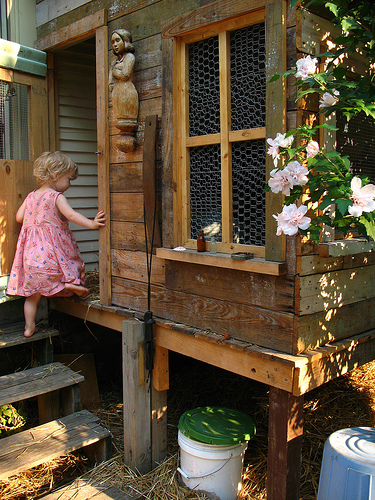

A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


In [87]:
#Flicker8k
im = Image.open('assets/EDA-VQA/demo/1000268201_693b08cb0e.jpeg')
display(im)
for i in range(5):
    caption = ann_fli[i].split(',')[1]
    print(caption)

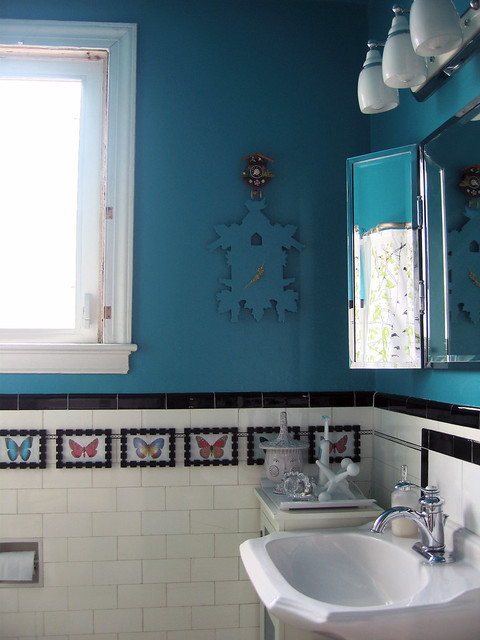

A very clean and well decorated empty bathroom
A panoramic view of a kitchen and all of its appliances.
A blue and white bathroom with butterfly themed wall tiles.
A panoramic photo of a kitchen and dining room
A graffiti-ed stop sign across the street from a red car 


In [88]:
#MSCOCO-Captions
im = Image.open('assets/EDA-VQA/demo/3378902101_3c9fa16b84_z.jpeg')
display(im)
for i in range(5):
    caption = ann_coco['caption'][i]
    print(caption)

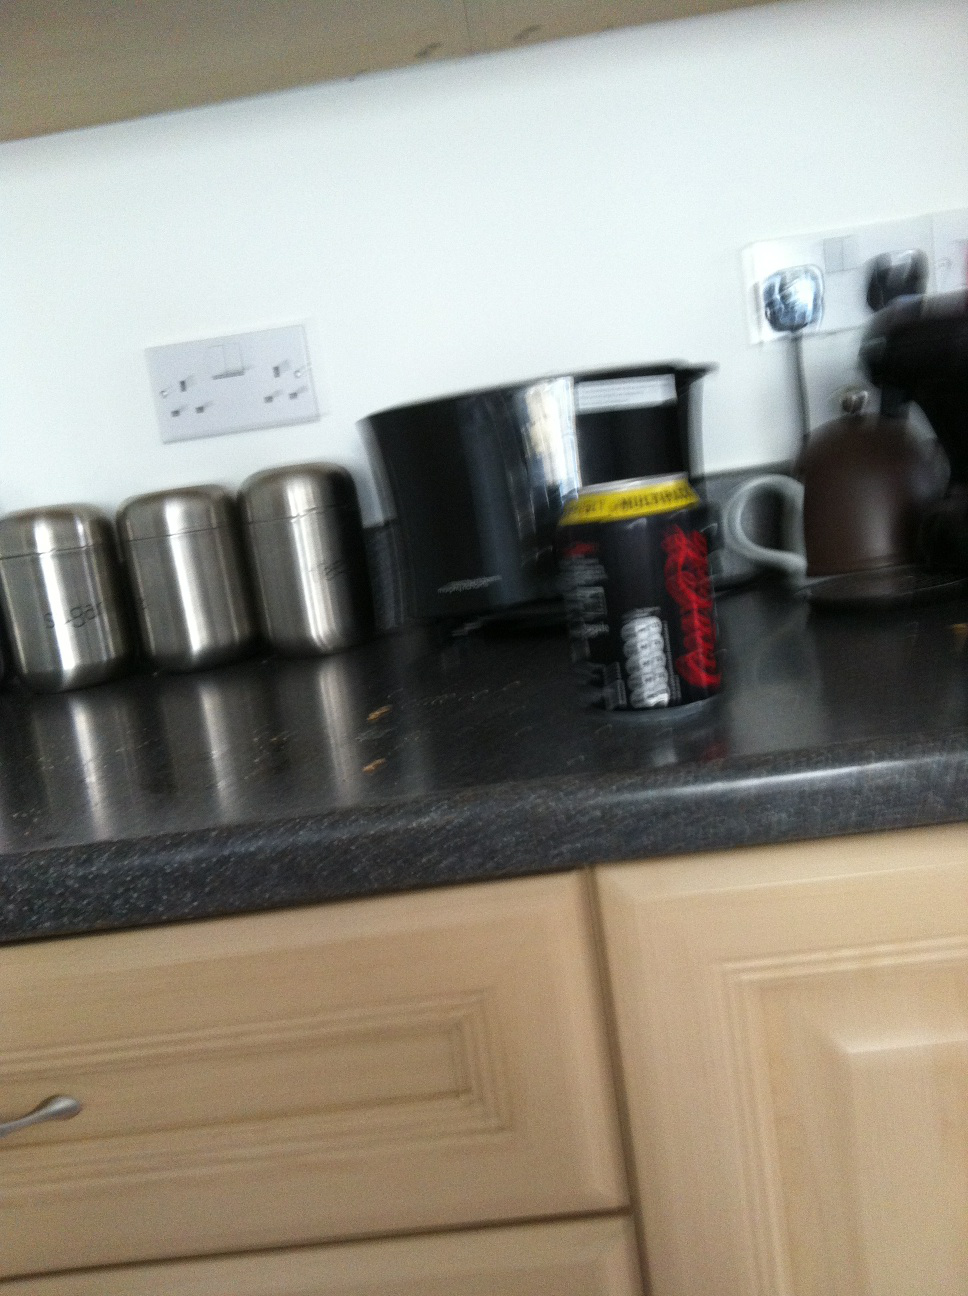

A can of Coca Cola on a counter is shown for when one can use a nice, cold drink.
A black can of Coca Cola Zero calorie soda is on the counter near the coffee maker.
A kitchen counter the various items on top including a can of Coca-Cola, metal containers, and a teapot.
a black tin of Coca Cola placed on a black surface
Black counter with canisters, kettle and can of soda.


In [89]:
#VizWiz-Captions
im = Image.open('assets/EDA-VQA/demo/VizWiz_train_00000001.jpeg')
display(im)
for i in range(5,10):
    caption = ann_vizwiz['caption'][i]
    print(caption)

#### The average count per caption: All Words, Nouns, Verbs, Colors, Adjectives, and Spatial Relation 

In this section, we want to compare the average count per caption in Flicker8k, MSCOCO-Captions, and VizWiz-Captions. First of all, we write a function that return the number of all words, nouns, verbs, colors, adjectives, and spatial relation in each dataset.

In order to find out the number of colors in captions of datasets, we use this file from this link: https://xkcd.com/color/rgb.txt

In [136]:
#read all colors of XKCD https://xkcd.com/color/rgb.txt
color_list = []
with open('assets/EDA-VQA/annotations/colors.txt') as color_file:
    for line in color_file:
        color_list.append(line.strip().split('\t')[0])

In [133]:
stop_words = []

def count(ann,name):   
    res = {}
    res['Word'] = 0
    res['Noun'] = 0
    res['Verb'] = 0
    res['Color'] = 0
    res['Spatial_Relation'] = 0
    res['Adj'] = 0
    
    his = {}
    his['Word'] = np.zeros(len(ann)).tolist()
    his['Noun'] = np.zeros(len(ann)).tolist()
    his['Verb'] = np.zeros(len(ann)).tolist()
    his['Color'] = np.zeros(len(ann)).tolist()
    his['Spatial_Relation'] = np.zeros(len(ann)).tolist()
    his['Adj'] = np.zeros(len(ann)).tolist()
    
    j=0
    
    for i in range(len(ann)):
        if name=='VizWiz':
            caption = ann['caption'][i].lower()
            if caption == 'quality issues are too severe to recognize visual content.':
                j=j+1
                continue
        elif name=='Nid' or name =='Sab':
            caption = ann[i].lower()
        elif name=='COCO':
            caption = ann['caption'][i].lower()
        else:
            caption = ann[i].split(',')[1].lower()
            if caption[0]=='"':
                caption = ' '.join(ann[i].split(',')[1:])[1:-1].lower()
        
        word_tokens = nltk.word_tokenize(caption.lower()) 
        words = [w for w in word_tokens if not w in stop_words]
        
        k=0
        for word in words:
            if word in color_list:
                 k+= 1        
        
        partsOfSpeechTags = nltk.pos_tag(words)
        partsOfSpeech = [wordResult[1] for wordResult in partsOfSpeechTags]
        
        tag_fd = nltk.FreqDist(partsOfSpeech)
        
        res['Color'] += k
        
        res['Noun'] += tag_fd['NN'] #noun, singular    'desk'
        res['Noun'] += tag_fd['NNS']  #noun, plural    'desks'

        res['Spatial_Relation'] += tag_fd['IN']#preposition/subordinating conjunction
 
        res['Adj'] += tag_fd['JJ']#adjective  for example: 'big'
        res['Adj'] += tag_fd['JJR']#bigger
        res['Adj'] += tag_fd['JJS']#biggest

        res['Verb'] += tag_fd['VB']#verb do
        res['Verb'] += tag_fd['VBD']#verb did
        res['Verb'] += tag_fd['VBG']#doing
        res['Verb'] += tag_fd['VBZ']#done

        res['Word'] += len(words)
        
        his['Word'][i] = len(words)
        his['Verb'][i] = tag_fd['VB'] + tag_fd['VBD'] + tag_fd['VBG'] + tag_fd['VBZ']
        his['Adj'][i] = tag_fd['JJ'] + tag_fd['JJR'] + tag_fd['JJS']
        his['Noun'][i] = tag_fd['NN'] + tag_fd['NNS']
        his['Spatial_Relation'][i] = tag_fd['IN']
        his['Color'][i] = k
        
            
    length = len(ann)
    res['n'] = length - j
    res['Word'] = res['Word']/res['n']
    res['Noun'] = res['Noun']/res['n']
    res['Verb'] = res['Verb']/res['n']
    res['Color'] = res['Color']/res['n']
    res['Adj'] = res['Adj']/res['n']
    res['Spatial_Relation'] = res['Spatial_Relation']/res['n']
    
    json.dump(res, open('assets/EDA-VQA/results/'+name+'_res.json', 'w'))
    json.dump(his, open('assets/EDA-VQA/results/'+name+'_his.json', 'w'))

    return res, his

In [126]:
r_coco, h_coco = count(ann_coco,'COCO')
r_viz, h_viz = count(ann_vizwiz,'VizWiz')
r_fli, h_fli = count(ann_fli,'Flicker')

In [127]:
#Import results from previous cells. 

r_coco = json.load(open('assets/EDA-VQA/results/COCO_res.json'))
h_coco = json.load(open('assets/EDA-VQA/results/COCO_his.json')) 

r_viz = json.load(open('assets/EDA-VQA/results/VizWiz_res.json'))
h_viz = json.load(open('assets/EDA-VQA/results/VizWiz_his.json')) 

r_fli = json.load(open('assets/EDA-VQA/results/Flicker_res.json'))
h_fli = json.load(open('assets/EDA-VQA/results/Flicker_his.json')) 

We define a function for plotting distribution, average, and number of all words, nouns, verbs, colors, adjectives, and spatial relation.

In [128]:
def plot_dist(name):
    print('The average count of '+ name.lower() +' per caption:')
    print('VizWiz:', r_viz[name])
    print('COCO:', r_coco[name])
    print('Flicker:', r_fli[name])


    bins = np.linspace(0, 30, 30)
    plt.figure(figsize=(16,4))
    plt.hist(h_coco[name], bins, alpha=0.5, label='COCO', density=True)
    plt.hist(h_viz[name], bins, alpha=0.5, label='VizWiz', density=True)
    plt.hist(h_fli[name], bins, alpha=0.5, label='Flicker', density=True)
    plt.xlabel("Number of "+ name.lower() +" per each caption")
    plt.ylabel("Density")

    plt.legend(loc='upper right')
    plt.show()


    fig = plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    labels=['COCO', 'VizWiz', 'Flicker']
    counts = [np.sum(h_coco[name]),np.sum(h_viz[name]), np.sum(h_fli[name])]
    plt.barh(labels, counts)
    plt.xlabel("Number of "+ name.lower())

    ax1 = fig.add_subplot(122)
    ax1.boxplot([h_coco[name],h_viz[name], h_fli[name]], labels=['COCO', 'VizWiz', 'Flicker'],patch_artist=True,
                showmeans=False, showfliers=False,)
    plt.ylabel("Number of "+ name.lower() +" per each caption")
    plt.show()


##### All Words

The average count of word per caption:
VizWiz: 12.95660832429801
COCO: 11.30171199172459
Flicker: 11.708985292300087


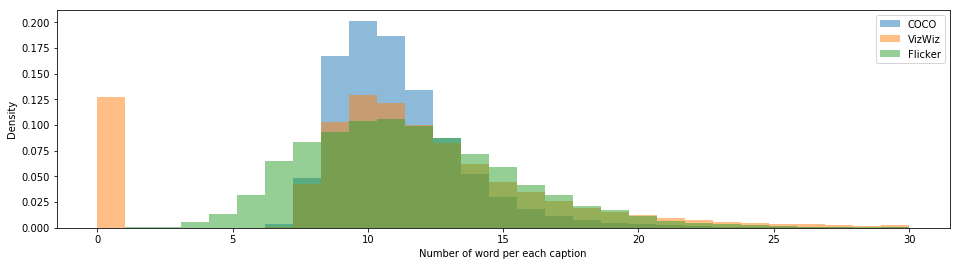

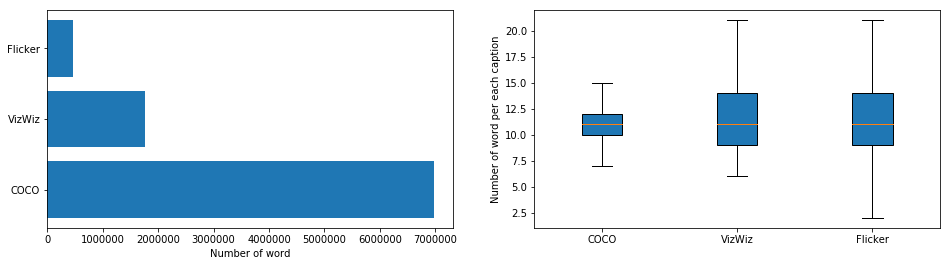

In [129]:
plot_dist('Word')

##### Nouns

The average count of noun per caption:
VizWiz: 4.382330596921352
COCO: 3.6991294929851954
Flicker: 3.663997033741194


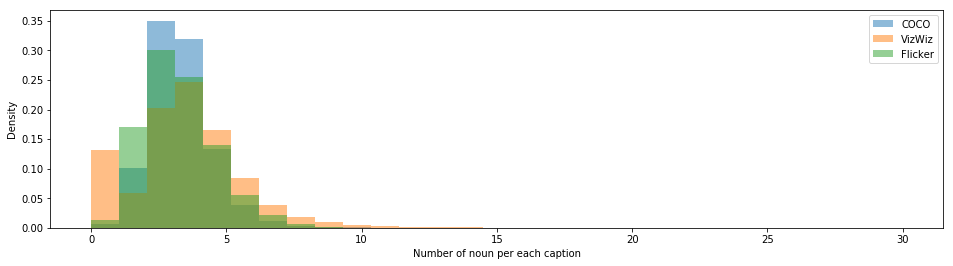

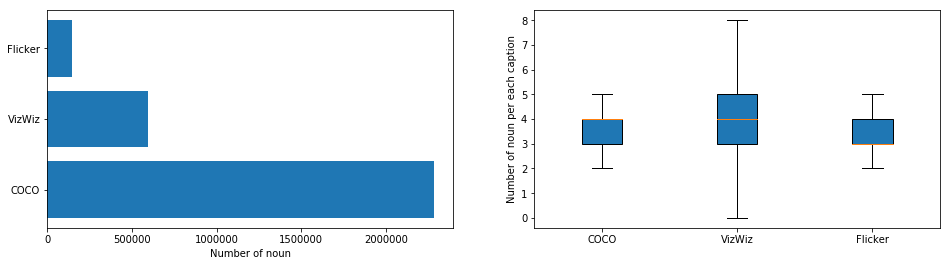

In [130]:
plot_dist('Noun')

##### Verbs

The average count of verb per caption:
VizWiz: 0.882031878093215
COCO: 0.9628822553735852
Flicker: 1.2062044246693857


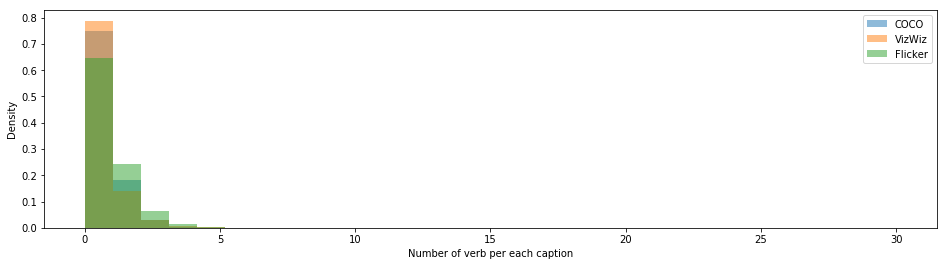

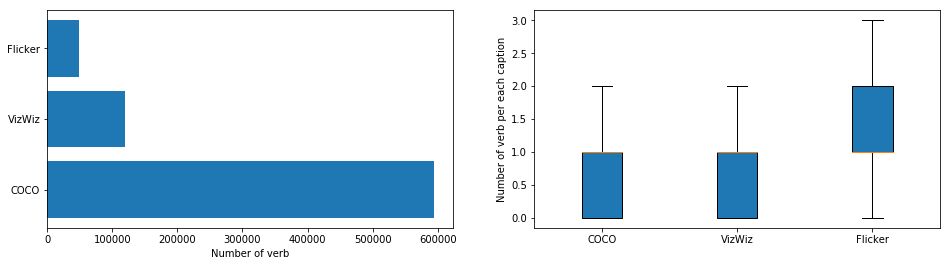

In [131]:
plot_dist('Verb')

##### Adjectives

The average count of adj per caption:
VizWiz: 1.4502614711717892
COCO: 0.8662558145944903
Flicker: 1.0211345939933258


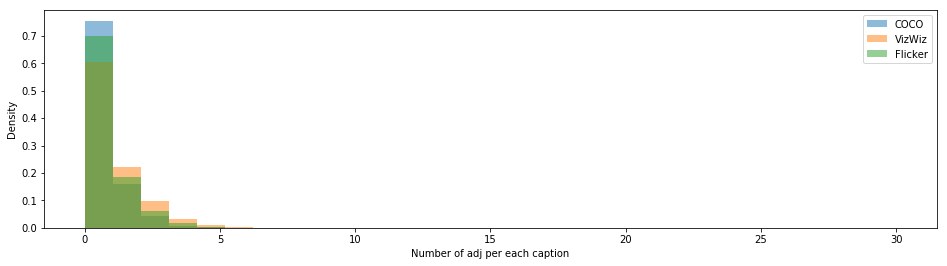

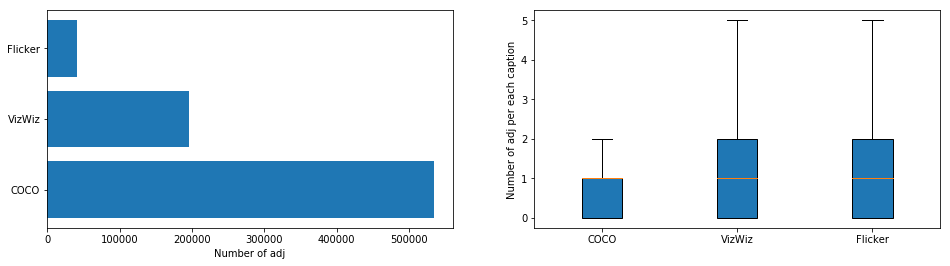

In [132]:
plot_dist('Adj')

##### Colors

The average count of color per caption:
VizWiz: 0.7908378141157554
COCO: 0.32598371832474826
Flicker: 0.6336917562724015


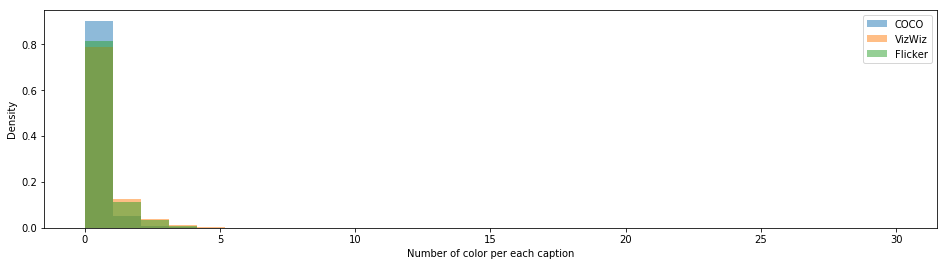

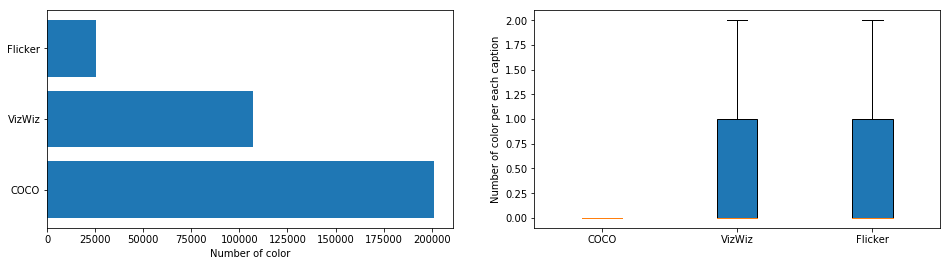

In [133]:
plot_dist('Color')

##### Spatial Relation

The average count of spatial_relation per caption:
VizWiz: 1.919884347870983
COCO: 1.6787084912130512
Flicker: 1.6021752564577927


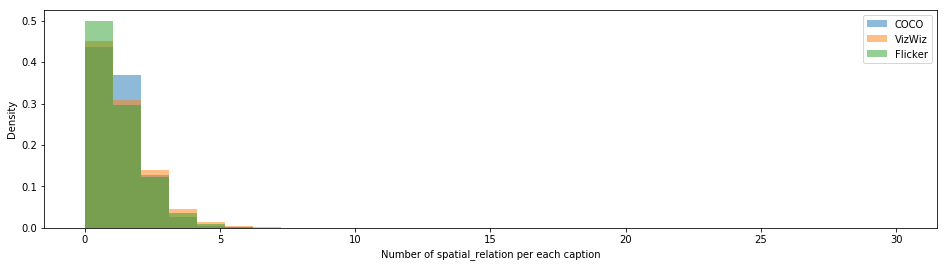

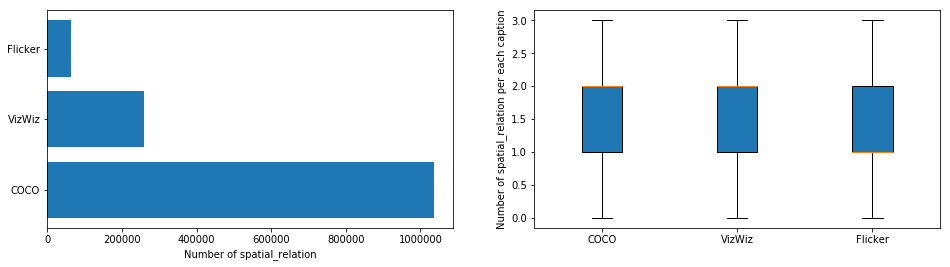

In [135]:
plot_dist('Spatial_Relation')

Interestingly, distributions of nouns, adj, spatial relation, and verb are approximately the same in each of datasets. The average length of each caption in these datasets is 11-13 words, though the interval of the length of each caption in VizWiz and Flicker is higher than MSCOCO. VizWiz has a higher average noun, adjective, spatial relation, and color per caption, which makes producing captions for images of this dataset harder than other datasets. For example, the more adjectives in one caption, the more uncertainty for model to generate a caption. Becuase some images in VizWiz suffer from quality issues, we have some images without captions, which is indicated in the first figure.

#### Unique Count for All Images: All Words, Nouns, Verbs, Adjectives, 2-Grams, 3-Grams, and Spatial Relation 

In this section, we want to compare unique count for all images in Flicker8k, MSCOCO-Captions, and VizWiz-Captions. First of all, we write a function that return the number of unique all words, nouns, verbs, colors, adjectives, and spatial relation in each dataset.

In [99]:
stop_words = []
def unique_count(ann,name):
    res_uni = {}
    res_uni['Word'] = 0
    res_uni['Noun'] = 0
    res_uni['Adj'] = 0
    res_uni['Verb'] = 0
    res_uni['Spatial_Relation'] = 0
    res_uni['2-Gram'] = 0
    res_uni['3-Gram'] = 0
    
    word_uni = set()
    noun_uni = set()
    adj_uni = set()
    verb_uni = set()
    spa_rel_uni = set()
    two_gram_uni = set()
    three_gram_uni = set()

    
    for i in range(len(ann)):
        
        if name=='VizWiz' or name=='COCO':
            caption = ann['caption'][i].lower()
            if caption == 'quality issues are too severe to recognize visual content.':
                continue
        elif name=='Sab' or name=='Nid':
            caption = ann[i].lower()
        else:
            caption = ann[i].split(',')[1].lower()
            if caption[0]=='"':
                caption = ' '.join(ann[i].split(',')[1:])[1:-1].lower()

        word_tokens = nltk.word_tokenize(caption) 
        words = [w for w in word_tokens if not w in stop_words]
        
        partsOfSpeechTags = nltk.pos_tag(words)
        partsOfSpeech = [wordResult[1] for wordResult in partsOfSpeechTags]
        
        for j,pos in enumerate(partsOfSpeech):
            if pos == 'JJ' or pos == 'JJR' or pos == 'JJS':
                adj_uni.add(partsOfSpeechTags[j][0])
            if pos == 'NN' or pos == 'NNS':
                noun_uni.add(partsOfSpeechTags[j][0])
            if pos == 'VB' or pos == 'VBG' or pos == 'VBD' or pos == 'VBZ':
                verb_uni.add(partsOfSpeechTags[j][0])
            if pos == 'IN':
                spa_rel_uni.add(partsOfSpeechTags[j][0])
                
        bgs = nltk.ngrams(words,2)
        tgs = nltk.ngrams(words,3)
        fdist = nltk.FreqDist(bgs)
        fdist3 = nltk.FreqDist(tgs)
        for k,v in fdist.items():
            two_gram_uni.add(' '.join(k))
        for k,v in fdist3.items():
            three_gram_uni.add(' '.join(k))
        for word in words:
            word_uni.add(word)        
            
    res_uni['Noun'] = list(noun_uni)
    res_uni['Adj'] = list(adj_uni)
    res_uni['Verb'] = list(verb_uni)
    res_uni['Spatial_Relation'] = list(spa_rel_uni)
    res_uni['Word'] = list(word_uni)
    res_uni['2-Gram'] = list(two_gram_uni)
    res_uni['3-Gram'] = list(three_gram_uni)
            
    json.dump(res_uni, open('assets/EDA-VQA/results/'+name+'_unique.json', 'w'))
    return res_uni


In [24]:
r_u_coco = unique_count(ann_coco,'COCO')
r_u_viz = unique_count(ann_vizwiz,'VizWiz')
r_u_fli = unique_count(ann_fli,'Flicker')

In [10]:
#Import results from previous cells. 

r_u_coco = json.load(open('assets/EDA-VQA/results/COCO_unique.json'))
r_u_viz = json.load(open('assets/EDA-VQA/results/VizWiz_unique.json'))
r_u_fli = json.load(open('assets/EDA-VQA/results/Flicker_unique.json')) 

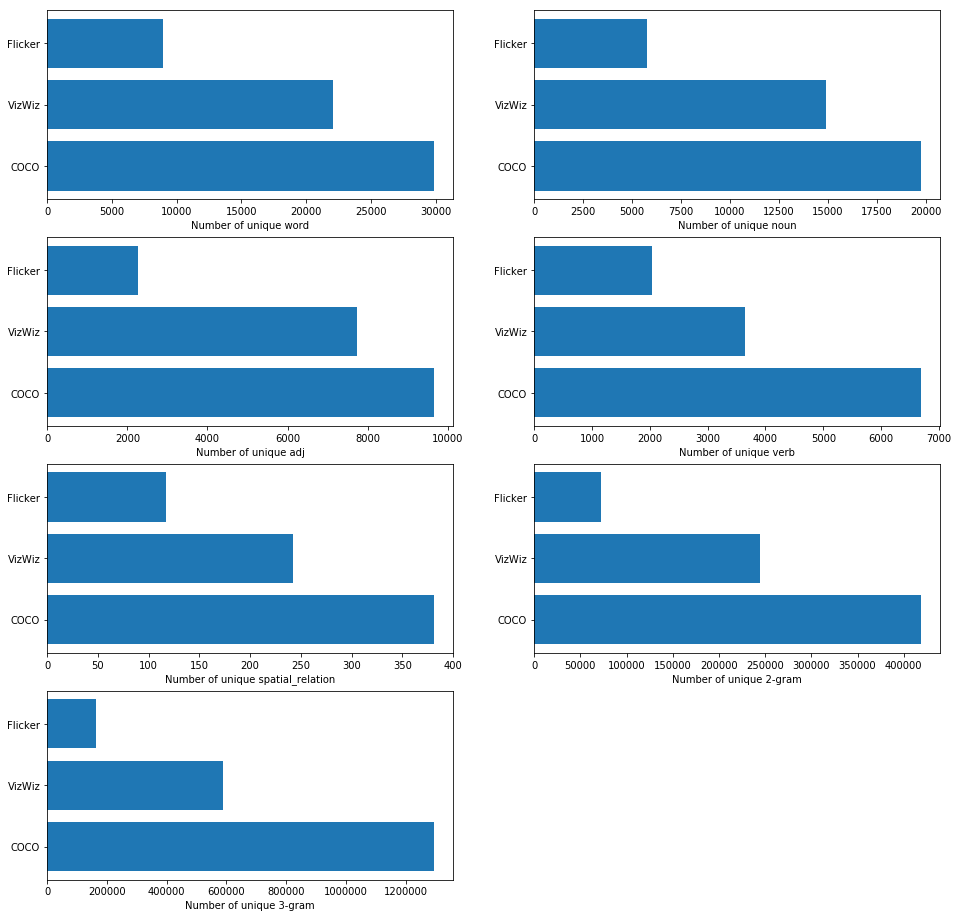

In [25]:
labels=['COCO', 'VizWiz', 'Flicker']
types =['Word','Noun','Adj','Verb','Spatial_Relation','2-Gram','3-Gram']

plt.figure(figsize=(16,16))
for i in range(421,428):
    plt.subplot(i)
    counts = [len(r_u_coco[types[i-421]]),len(r_u_viz[types[i-421]]), len(r_u_fli[types[i-421]])]
    plt.barh(labels, counts)
    plt.xlabel("Number of unique "+ types[i-421].lower())
plt.show()

Although VizWiz has much fewer captions than COCO, it seems the diversity of words of VizWiz is higher than COCO because VizWiz has approximately similar unique nouns and adjectives to COCO. COCO has more diverse verbs than other datasets.

#### Common Unique All Words, Nouns, Verbs, Adjectives, 2-Grams, 3-Grams, and Spatial Relation between 3 datasets.

In this part, we want to find out which percent of words, nouns, verbs, adjectives, 2-grams, 3-grams, and spatial relation are in common between these three datasets.

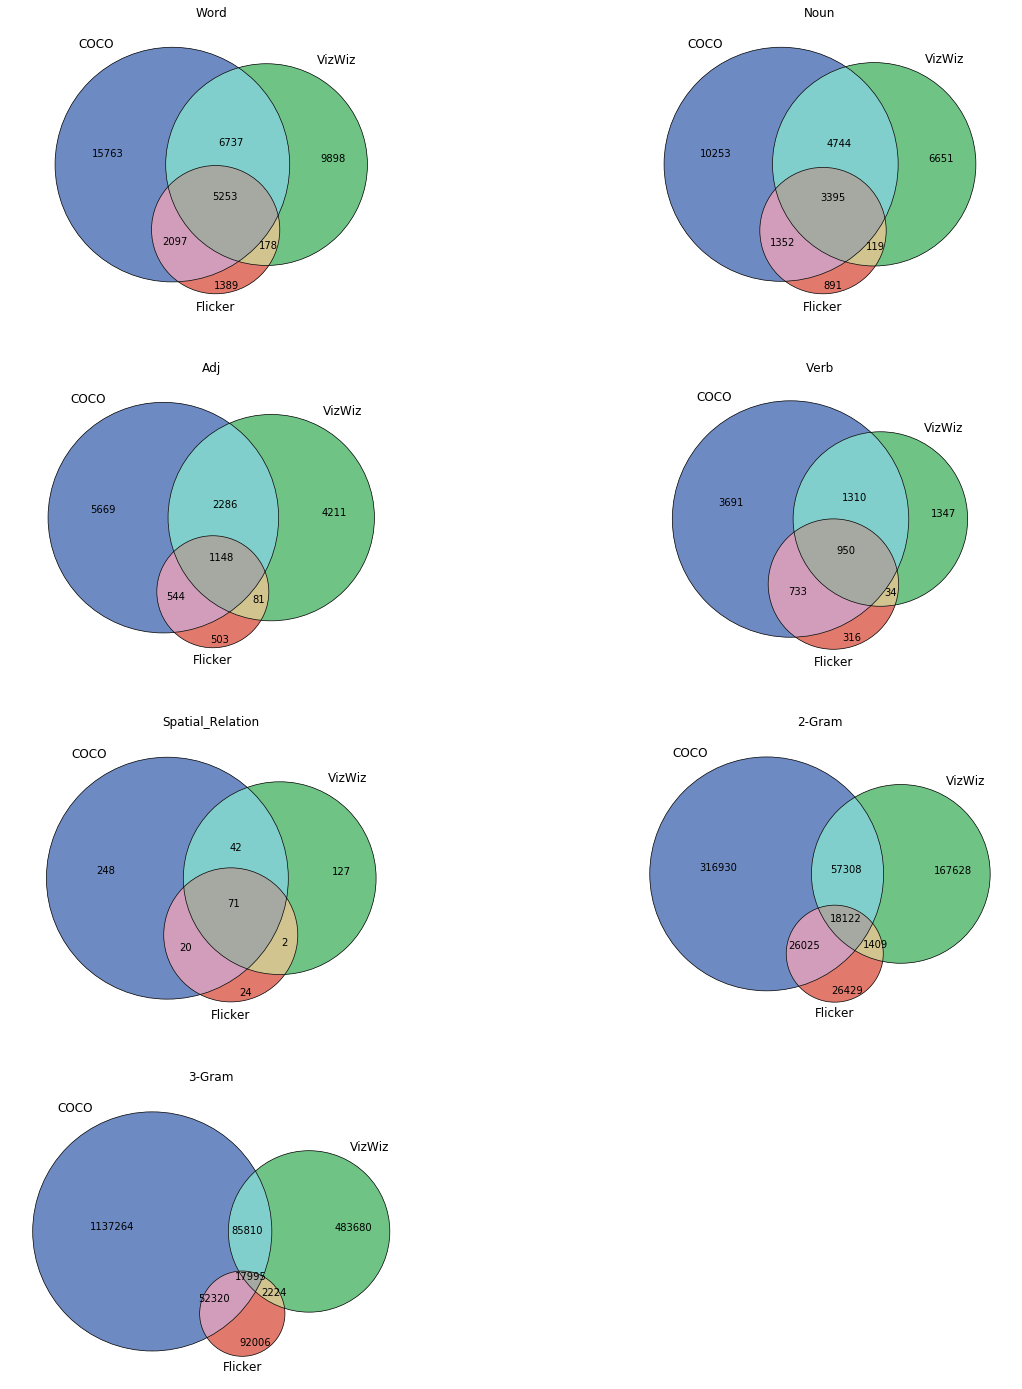

In [26]:
labels=['COCO', 'VizWiz', 'Flicker']
types =['Word','Noun','Adj','Verb','Spatial_Relation','2-Gram','3-Gram']

plt.figure(figsize=(20,25))
for i in range(421,428):
    plt.subplot(i)
    venn3([set(r_u_coco[types[i-421]]), set(r_u_viz[types[i-421]]), set(r_u_fli[types[i-421]])],
      set_colors=('#3E64AF', '#3EAF5D', '#D74E3B'), 
      set_labels = ('COCO', 
                    'VizWiz',
                    'Flicker'),
      alpha=0.75)
    venn3_circles([set(r_u_coco[types[i-421]]), set(r_u_viz[types[i-421]]), set(r_u_fli[types[i-421]])], lw=0.7)
    plt.gca().title.set_text(types[i-421]) 
plt.show()

Based on plots, we can find out differences between VizWiz and COCO are further than the differences between Flicker and COCO. It means that VizWiz has more share of nouns and adjectives that have not been seen in COCO rather than Flicker. So, it seems a model that is trained on COCO probably does well on Flicker, not VizWiz. 2-Grams and 3-Grams of these three datasets do not have overlaps like other things like verbs and nouns.

#### Most Common All Words, Nouns, Verbs, Adjectives, and Spatial Relation in 3 datasets.

In this section, we want to find out which words, nouns, verbs, adjectives, and spatial relation are the most common in these datasets. In this way, we can indicate common words among these datasets.

In [28]:
def most_common(ann,name):
    res_uni = {}
    res_uni['Word'] = 0
    res_uni['Noun'] = 0
    res_uni['Adj'] = 0
    res_uni['Verb'] = 0
    res_uni['Spatial_Relation'] = 0
    
    word_uni = []
    noun_uni = []
    adj_uni = []
    verb_uni = []
    spa_rel_uni = []

    
    for i in range(len(ann)):
        
        if name=='VizWiz' or name=='COCO':
            caption = ann['caption'][i].lower()
            if caption == 'quality issues are too severe to recognize visual content.':
                continue
        else:
            caption = ann[i].split(',')[1].lower()
            if caption[0]=='"':
                caption = ' '.join(ann[i].split(',')[1:])[1:-1].lower()

        word_tokens = nltk.word_tokenize(caption) 
        words = [w for w in word_tokens if not w in stop_words]
        
        partsOfSpeechTags = nltk.pos_tag(words)
        partsOfSpeech = [wordResult[1] for wordResult in partsOfSpeechTags]
        
        for j,pos in enumerate(partsOfSpeech):
            if pos == 'JJ' or pos == 'JJR' or pos == 'JJS':
                adj_uni.append(partsOfSpeechTags[j][0])
            if pos == 'NN' or pos == 'NNS':
                noun_uni.append(partsOfSpeechTags[j][0])
            if pos == 'VB' or pos == 'VBG' or pos == 'VBD' or pos == 'VBZ':
                verb_uni.append(partsOfSpeechTags[j][0])
            if pos == 'IN':
                spa_rel_uni.append(partsOfSpeechTags[j][0])
                
        for word in words:
            word_uni.append(word)        
            
    res_uni['Noun'] = noun_uni
    res_uni['Adj'] = adj_uni
    res_uni['Verb'] = verb_uni
    res_uni['Spatial_Relation'] = spa_rel_uni
    res_uni['Word'] = word_uni
            
    json.dump(res_uni, open('assets/EDA-VQA/results/'+name+'_common.json', 'w'))
    return res_uni

In [30]:
r_c_coco = most_common(ann_coco,'COCO')
r_c_viz = most_common(ann_vizwiz,'VizWiz')
r_c_fli = most_common(ann_fli,'Flicker')

In [ ]:
#Import results from previous cells. 

r_c_coco = json.load(open('assets/EDA-VQA/results/COCO_common.json'))
r_c_viz = json.load(open('assets/EDA-VQA/results/VizWiz_common.json'))
r_c_fli = json.load(open('assets/EDA-VQA/results/Flicker_common.json')) 

Word:


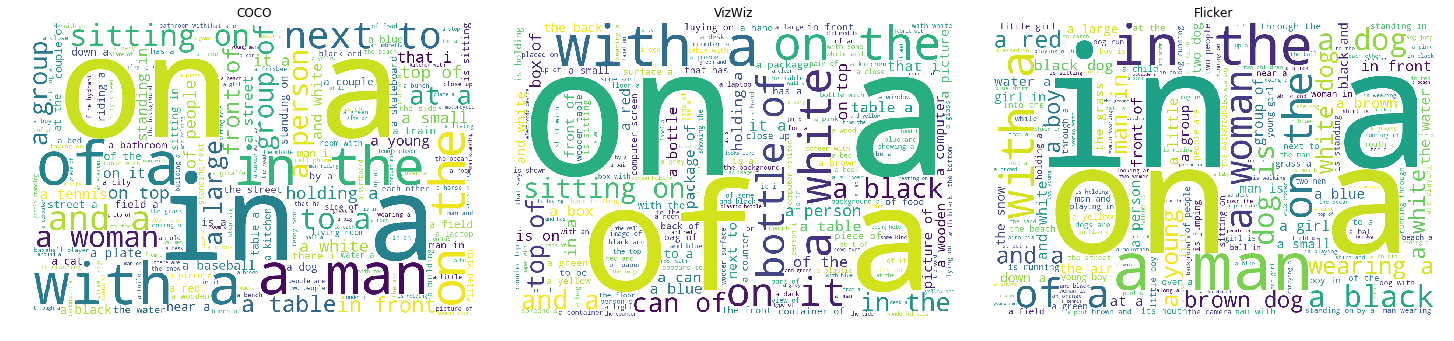


Noun:


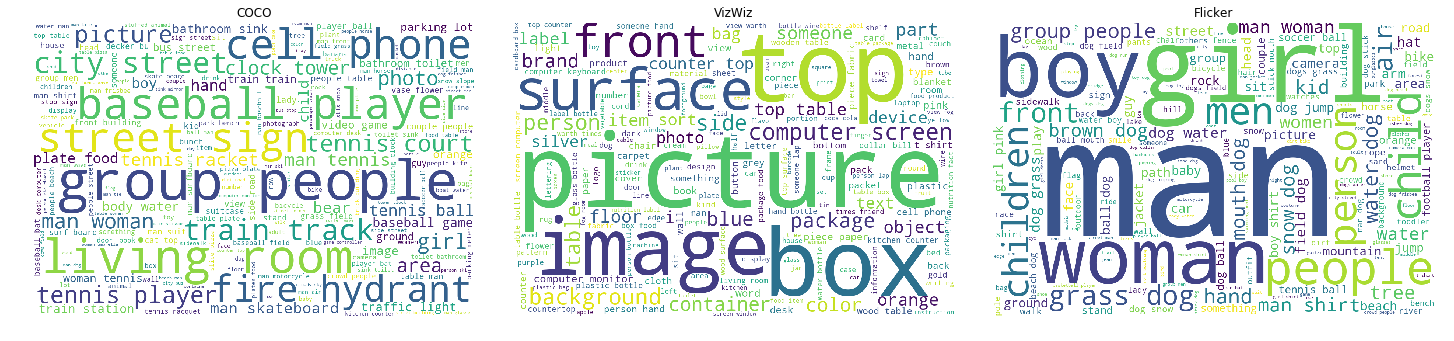


Adj:


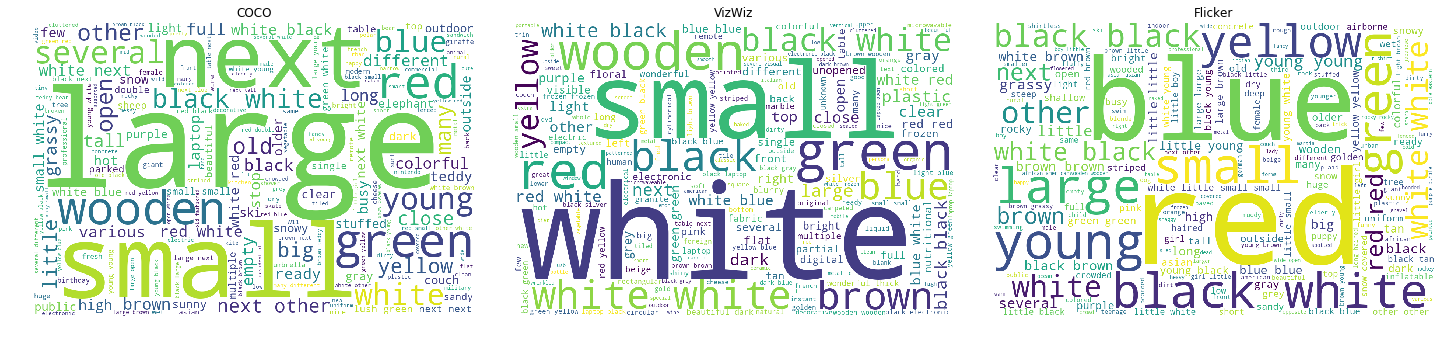


Verb:


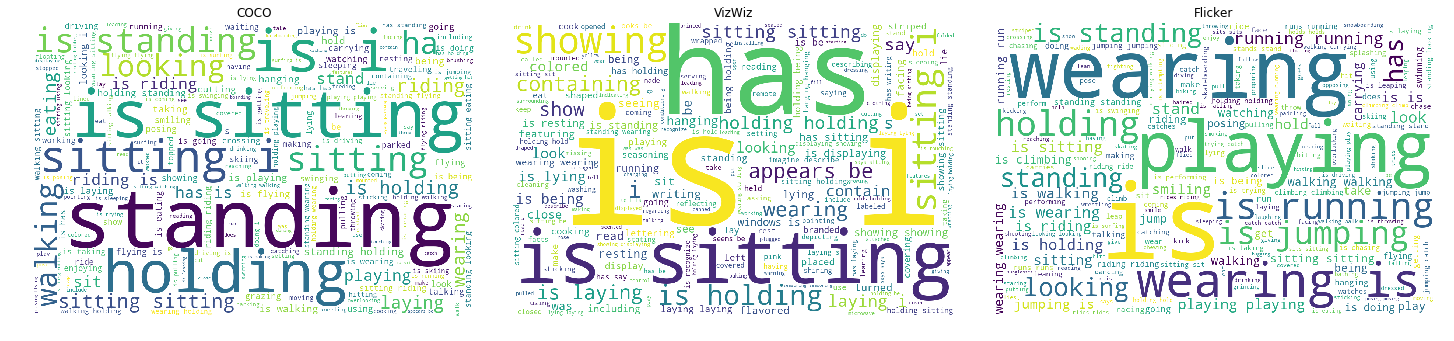


Spatial_Relation:


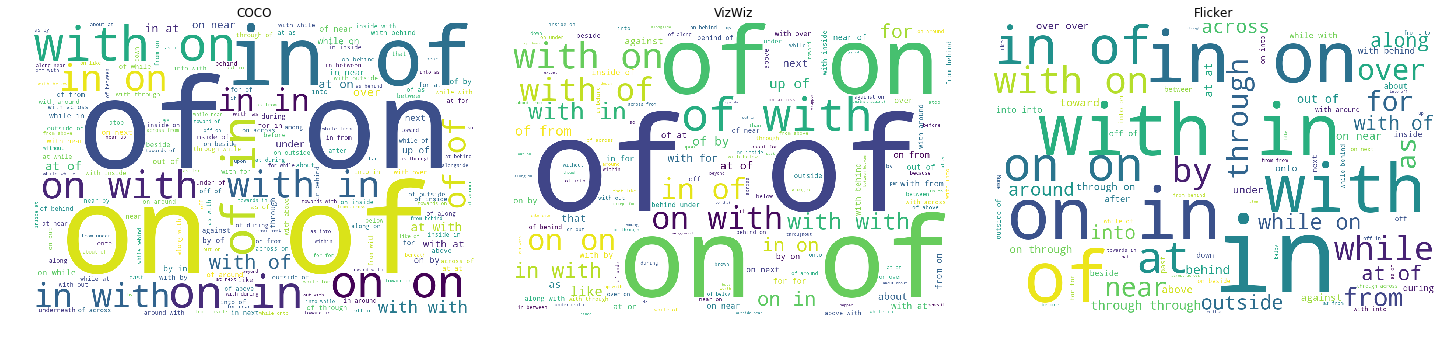

In [31]:
labels=['COCO', 'VizWiz', 'Flicker']
types =['Word','Noun','Adj','Verb','Spatial_Relation']


tmp = [r_c_coco,r_c_viz,r_c_fli]

for i in range(5):
    print(types[i]+':')
    plt.figure(figsize=(20,20))
    for j in range(3):
        plt.subplot(1,3,j+1)

        wordcloud = WordCloud(width = 1200, height = 800,
                    background_color ='white',
                    stopwords = '',
                    min_font_size = 10).generate(' '.join(tmp[j][types[i]]))
        
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad = 0)
        plt.gca().title.set_text(labels[j]) 

    plt.show()
    print()

The most common nouns in Flicker are "Man", "Girl", "Women", etc, which are different from the most common nouns in VizWiz and COCO. Also, there is more similarity between adjectives in VizWiz and COCO than Flicker and other datasets. "is sitting" and "is holding" are verbs that can be seen in both of VizWiz and COCO. Adjectives in COCO are mostly related to size, and adjectives in Flicker often are related to color, but adjectives in VizWiz seem more balanced.

#### Plotting 3-Grams sunburst for each dataset.

In [109]:
stop_words = []

def three_grams(ann,name):

    three_gram_uni = []

    for i in range(len(ann)):
        
        if name=='VizWiz' or name=='COCO':
            caption = ann['caption'][i].lower()
            if caption == 'quality issues are too severe to recognize visual content.':
                continue
        elif name=='Sab' or name=='Nid':
            caption = ann[i].lower()
        else:
            caption = ann[i].split(',')[1].lower()
            if caption[0]=='"':
                caption = ' '.join(ann[i].split(',')[1:])[1:-1].lower()

        word_tokens = nltk.word_tokenize(caption) 
        words = [w for w in word_tokens if not w in stop_words]

        tmp = list(nltk.ngrams(words,3))

        for i in range(len(tmp)):
            three_gram_uni.append(' '.join(tmp[i]))
            
    json.dump(three_gram_uni, open('assets/EDA-VQA/results/'+name+'_3grams.json', 'w'))
    return three_gram_uni


In [40]:
r_3_coco = three_grams(ann_coco,'COCO')
r_3_viz = three_grams(ann_vizwiz,'VizWiz')
r_3_fli = three_grams(ann_fli,'Flicker')

In [41]:
#Import results from previous cells. 

r_3_coco = json.load(open('assets/EDA-VQA/results/COCO_3grams.json'))
r_3_viz = json.load(open('assets/EDA-VQA/results/VizWiz_3grams.json'))
r_3_fli = json.load(open('assets/EDA-VQA/results/Flicker_3grams.json')) 

In [42]:
def plot_distribution(ann):
    
    # We count unique values of the list and sort them.

    first_second_third_c = Counter(ann)
    first_second_third_sorted = sorted(first_second_third_c.items(), key=lambda x: x[1], reverse=True)
    
    # Now, we should create the tree of that plot

    first_words = []
    second_words = []
    third_words = []
    values = []
    i = 0
    for question, value in first_second_third_sorted:
        i=i+1
        if i>200:
            break
        q = question.split(" ")
        if len(q)>0:
            first_words.append(q[0])
        if len(q)>1:
            second_words.append(q[1])
        else:
            second_words.append('N/A')
        if len(q)>2:
            third_words.append(q[2])
        else:
            third_words.append('N/A')
        values.append(value)   
    
    # We create dataframe and print sorted questions
    
    df = pd.DataFrame(
        dict(first_words=first_words, second_words=second_words, third_words=third_words, values=values)
    )
    print(df)
    
    # Show the plot
    
    fig = px.sunburst(df, path=['first_words','second_words','third_words' ], values='values',width=1200, height=1200)
    fig.show(renderer="png")

    return

Sorted all 3-Grams in COCO:

    first_words second_words third_words  values
0          next           to           a   23416
1             a        group          of   19433
2            in        front          of   18087
3            on          top          of   16499
4       sitting           on           a   15007
..          ...          ...         ...     ...
195      parked           on         the    1700
196     sitting           in       front    1694
197          on          the       table    1684
198         man          and       woman    1684
199         and        white       photo    1674

[200 rows x 4 columns]


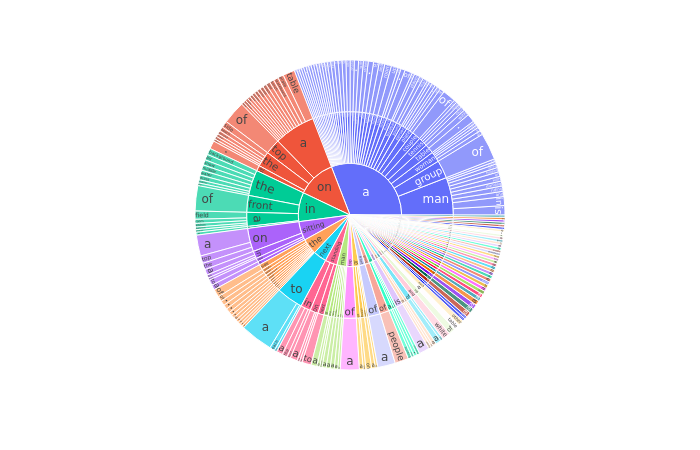

Sorted all 3-Grams in VizWiz:

    first_words second_words third_words  values
0       sitting           on           a    5417
1            on          top          of    5316
2             a          can          of    4516
3           top           of           a    4439
4             a       bottle          of    4382
..          ...          ...         ...     ...
195           a       living        room     379
196          of         some        kind     379
197     portion           of           a     376
198           a         pack          of     376
199           a         desk           .     376

[200 rows x 4 columns]


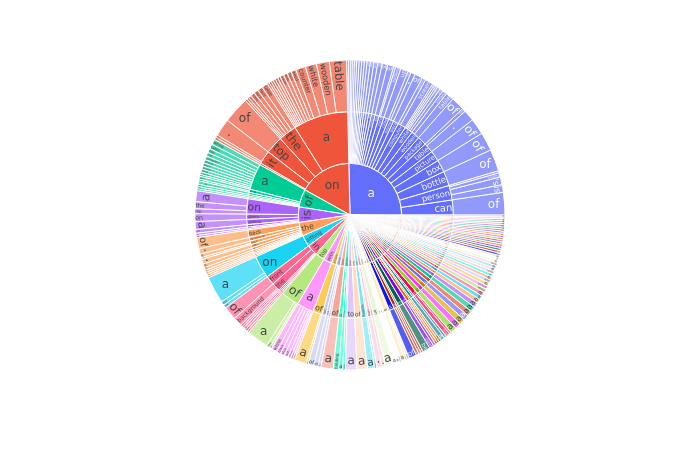

Sorted all 3-Grams in Flicker:

    first_words second_words third_words  values
0            in        front          of    1304
1             a          man          in    1087
2             a        group          of    1058
3         front           of           a     876
4           man           in           a     847
..          ...          ...         ...     ...
195       green        grass           .     123
196     jumping           in         the     123
197         the       ground           .     122
198       young         girl          in     122
199          in          the      middle     122

[200 rows x 4 columns]


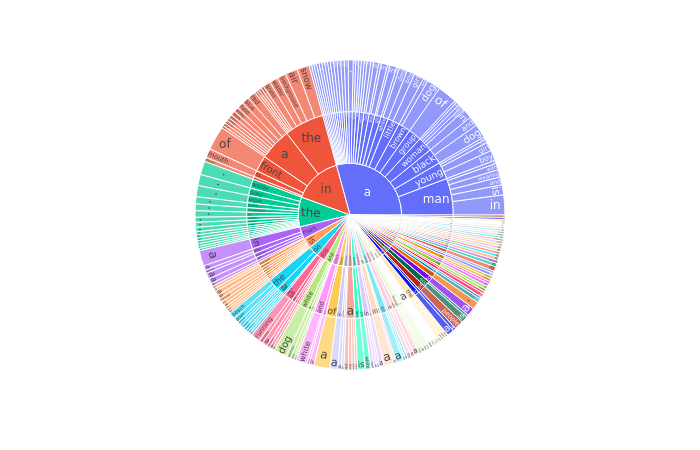

In [43]:
print('Sorted all 3-Grams in COCO:')
print()
plot_distribution(r_3_coco)

print('Sorted all 3-Grams in VizWiz:')
print()
plot_distribution(r_3_viz)

print('Sorted all 3-Grams in Flicker:')
print()
plot_distribution(r_3_fli)

In the top 5 3-grams of each dataset:

    "sitting on a" and "on top of" are in common between COCO and VizWiz.
    "a group of" and "in front of" are 3-grams in common between COCO and Flicker.
    VizWiz and Flicker do not have anything in common.
  
Portion of 3-grams that are started with "a" is the same in Flicker and COCO. COCO and VizWiz have more portion of 3-grams started with "on" than Flicker.

    COCO 3-grams mostly started with "a", "on", "in".
    VizWiz 3-grams mostly started with "a", "on", "of".
    Flicker 3-grams mostly started with "a", "in", "the".

#### Where are these images taken? - Scene Categories

We want to use places365 dataset categories, which is a scene classification dataset. By using string matching and finding scene categories in captions, we want to find out which percent of images of each dataset are taken in that location. Although there may be some errors, we can get a good understanding of these plots.

You can download places365 categories from this link: https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt

In [44]:
# Do some pre-processing on these categories.
my_file = open('assets/EDA-VQA/annotations/categories_places365.txt', "r")
scene_lines = my_file.read().splitlines()
scene_cat = set()
for scene in scene_lines:
    tmp = scene.split('/')[2]
    tmp = tmp.split(' ')[0]
    tmp = tmp.split('_')
    if len(tmp)>1:
        tmp = ' '.join(tmp)
    else:
        tmp = tmp[0]
    scene_cat.add(tmp)
scene_cat = list(scene_cat)

In [45]:
def count_scene(ann,name):
    
    hist = np.zeros(len(scene_cat))
    tmp = np.zeros(len(scene_cat))
    for i in range(len(ann)):
        if i%5 == 0:
            hist = hist + tmp
            tmp = np.zeros(len(scene_cat))
        if name=='VizWiz' or name=='COCO':
            caption = ann['caption'][i].lower()
            if caption == 'quality issues are too severe to recognize visual content.':
                continue
        else:
            caption = ann[i].split(',')[1].lower()
            if caption[0]=='"':
                caption = ' '.join(ann[i].split(',')[1:])[1:-1].lower()

        for j in range(len(scene_cat)):
            if caption.find(' '+scene_cat[j]+' ')!=-1:
                tmp[j]=1
            if caption.find(scene_cat[j]+' ')==0:
                tmp[j]=1
            if caption.find(' '+scene_cat[j])==len(caption)-len(' '+scene_cat[j]) and len(caption)-len(' '+scene_cat[j])!=-1:
                tmp[j]=1
            
    json.dump(list(hist), open('assets/EDA-VQA/results/'+name+'_scene.json', 'w'))
    return list(hist)

In [46]:
r_s_coco = count_scene(ann_coco,'COCO')
r_s_viz = count_scene(ann_vizwiz,'VizWiz')
r_s_fli = count_scene(ann_fli,'Flicker')

In [47]:
#Import results from previous cells. 

r_s_coco = json.load(open('assets/EDA-VQA/results/COCO_scene.json'))
r_s_viz = json.load(open('assets/EDA-VQA/results/VizWiz_scene.json'))
r_s_fli = json.load(open('assets/EDA-VQA/results/Flicker_scene.json')) 

Now, we want to plot places that are in common between these three dataset.

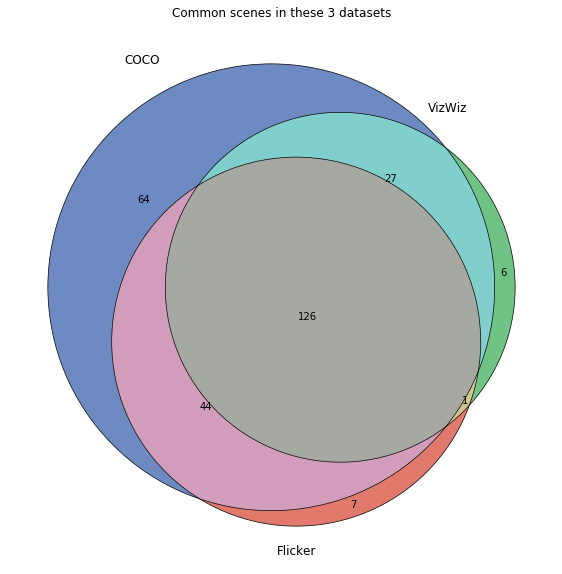

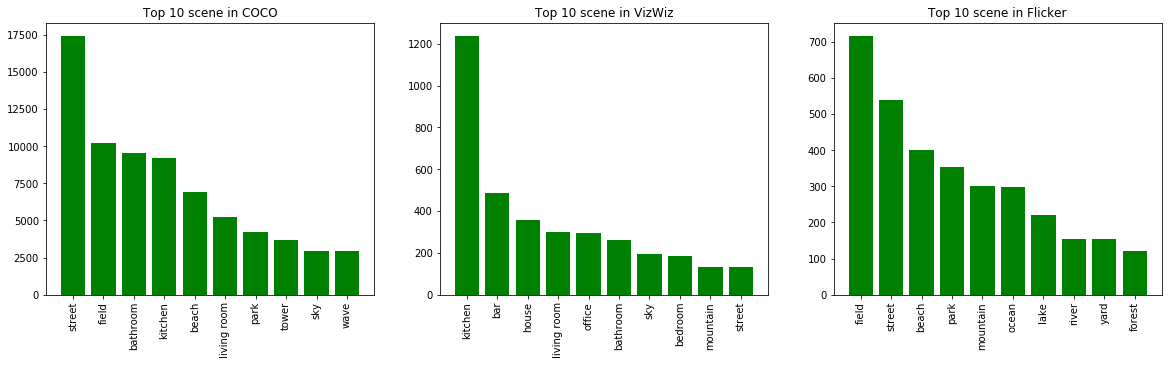

In [48]:
r_s_coco_cat = set()
r_s_viz_cat = set()
r_s_fli_cat = set()

for i in range(len(scene_cat)):
    if r_s_coco[i]>0:
        r_s_coco_cat.add(scene_cat[i])
    if r_s_viz[i]>0:
        r_s_viz_cat.add(scene_cat[i])
    if r_s_fli[i]>0:
        r_s_fli_cat.add(scene_cat[i])


plt.figure(figsize=(10,10))

venn3([r_s_coco_cat, r_s_viz_cat, r_s_fli_cat],
  set_colors=('#3E64AF', '#3EAF5D', '#D74E3B'), 
  set_labels = ('COCO', 
                'VizWiz',
                'Flicker'),
  alpha=0.75)

venn3_circles([r_s_coco_cat, r_s_viz_cat, r_s_fli_cat], lw=0.7)
plt.gca().title.set_text('Common scenes in these 3 datasets') 

r_s_coco_cat = []
r_s_viz_cat = []
r_s_fli_cat = []

r_s_coco_value = []
r_s_viz_value = []
r_s_fli_value = []

r_s_coco_sorted = np.argsort(r_s_coco)[::-1][:10]
r_s_viz_sorted = np.argsort(r_s_viz)[::-1][:10]
r_s_fli_sorted = np.argsort(r_s_fli)[::-1][:10]

for i in range(10):
    r_s_coco_cat.append(scene_cat[r_s_coco_sorted[i]])
    r_s_coco_value.append(r_s_coco[r_s_coco_sorted[i]])
    r_s_viz_cat.append(scene_cat[r_s_viz_sorted[i]])
    r_s_viz_value.append(r_s_viz[r_s_viz_sorted[i]])
    r_s_fli_cat.append(scene_cat[r_s_fli_sorted[i]])
    r_s_fli_value.append(r_s_fli[r_s_fli_sorted[i]])

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.bar(r_s_coco_cat, r_s_coco_value, color='green')
plt.xticks(rotation=90)
plt.gca().title.set_text('Top 10 scene in COCO') 

plt.subplot(1,3,2)
plt.bar(r_s_viz_cat, r_s_viz_value, color='green')
plt.xticks(rotation=90)
plt.gca().title.set_text('Top 10 scene in VizWiz') 

plt.subplot(1,3,3)
plt.bar(r_s_fli_cat, r_s_fli_value, color='green')
plt.xticks(rotation=90)
plt.gca().title.set_text('Top 10 scene in Flicker') 

plt.show()

Based on these plots, it seems that pictures in VizWiz are mostly indoor, but images in Flicker and COCO are outdoor, which can be an important issue. Another important point is COCO approximately can cover all scenes in VizWiz and Flicker, though it may have some biases to outdoor scenes. The overlap between VizWiz and Flicker is not much as the overlap between COCO and other datasets.

#### Which objects do these images contain? - Object Categories

Like the past section, we want to use ImageNet dataset categories, which is a image classification dataset. By using string matching and finding object categories in captions, we want to find out which percent of images of each dataset contain that object.

You can download ImageNet categories from this link: 
https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [49]:
# Do some pre-processing on these categories.
my_file = open('assets/EDA-VQA/annotations/categories_imagenet.txt', "r")
object_lines = my_file.read().splitlines()
object_cat = []
for line in object_lines:
    tmp = line.split(': ')[1]
    tmp = tmp[1:-2]
    tmp = tmp.split(', ')
    object_cat.append(tmp)

In [50]:
def count_object(ann,name):
    
    hist = np.zeros(len(object_cat))
    tmp = np.zeros(len(object_cat))
    
    for i in range(len(ann)):
        if i%5 == 0:
            hist = hist + tmp
            tmp = np.zeros(len(object_cat))
        if name=='VizWiz' or name=='COCO':
            caption = ann['caption'][i].lower()
            if caption == 'quality issues are too severe to recognize visual content.':
                continue
        else:
            caption = ann[i].split(',')[1].lower()        
            if caption[0]=='"':
                caption = ' '.join(ann[i].split(',')[1:])[1:-1].lower()
        
        for j in range(len(object_cat)):
            for k in range(len(object_cat[j])):
                if caption.find(' '+ object_cat[j][k]+' ')!=-1: 
                    tmp[j]=1
                    break
                if caption.find(object_cat[j][k]+' ')==0:
                    tmp[j]=1
                    break
                if caption.find(' '+object_cat[j][k])==len(caption)-len(' '+object_cat[j][k]) and len(caption)-len(' '+object_cat[j][k])!=-1:
                    tmp[j]=1
                    break
                    
            
    json.dump(list(hist), open('assets/EDA-VQA/results/'+name+'_object.json', 'w'))
    return list(hist)

In [51]:
r_o_coco = count_object(ann_coco,'COCO')
r_o_viz = count_object(ann_vizwiz,'VizWiz')
r_o_fli = count_object(ann_fli,'Flicker')

In [52]:
#Import results from previous cells. 

r_o_coco = json.load(open('assets/EDA-VQA/results/COCO_object.json'))
r_o_viz = json.load(open('assets/EDA-VQA/results/VizWiz_object.json'))
r_o_fli = json.load(open('assets/EDA-VQA/results/Flicker_object.json')) 

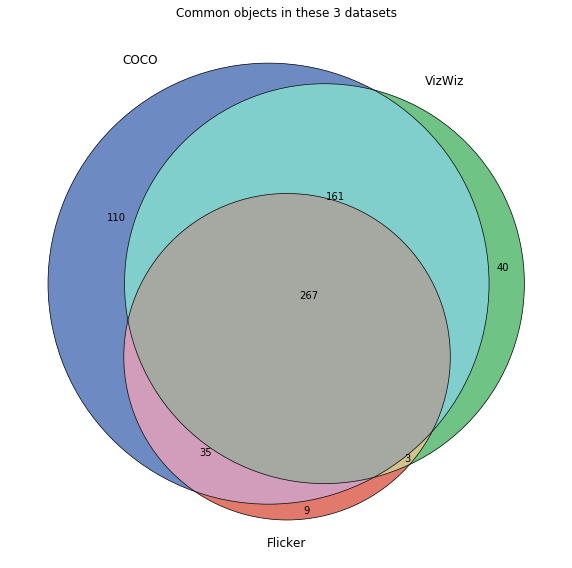

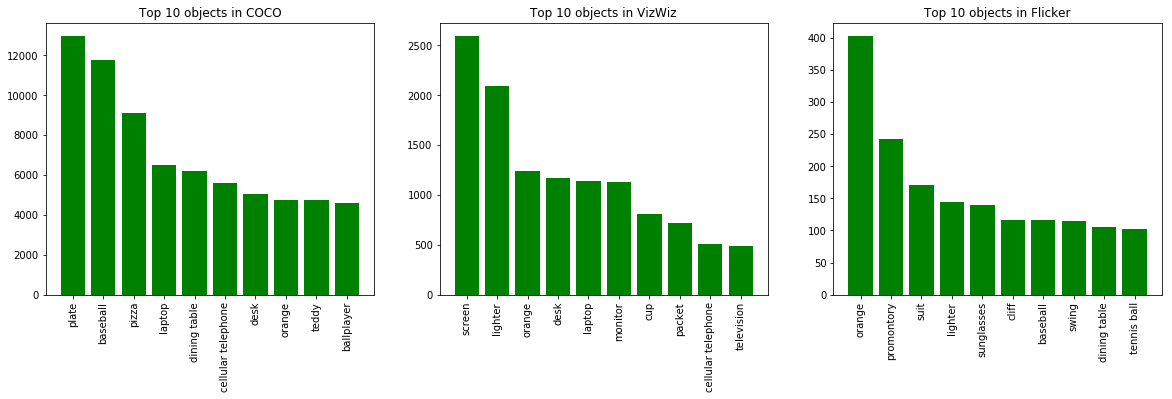

In [53]:
r_o_coco_cat = set()
r_o_viz_cat = set()
r_o_fli_cat = set()

for i in range(len(object_cat)):
    if r_o_coco[i]>0:
        r_o_coco_cat.add(object_cat[i][0])
    if r_o_viz[i]>0:
        r_o_viz_cat.add(object_cat[i][0])
    if r_o_fli[i]>0:
        r_o_fli_cat.add(object_cat[i][0])


plt.figure(figsize=(10,10))

venn3([r_o_coco_cat, r_o_viz_cat, r_o_fli_cat],
  set_colors=('#3E64AF', '#3EAF5D', '#D74E3B'), 
  set_labels = ('COCO', 
                'VizWiz',
                'Flicker'),
  alpha=0.75)

venn3_circles([r_o_coco_cat, r_o_viz_cat, r_o_fli_cat], lw=0.7)
plt.gca().title.set_text('Common objects in these 3 datasets') 

r_o_coco_cat = []
r_o_viz_cat = []
r_o_fli_cat = []

r_o_coco_value = []
r_o_viz_value = []
r_o_fli_value = []

r_o_coco_sorted = np.argsort(r_o_coco)[::-1][:10]
r_o_viz_sorted = np.argsort(r_o_viz)[::-1][:10]
r_o_fli_sorted = np.argsort(r_o_fli)[::-1][:10]

for i in range(10):
    r_o_coco_cat.append(object_cat[r_o_coco_sorted[i]][0])
    r_o_coco_value.append(r_o_coco[r_o_coco_sorted[i]])
    r_o_viz_cat.append(object_cat[r_o_viz_sorted[i]][0])
    r_o_viz_value.append(r_o_viz[r_o_viz_sorted[i]])
    r_o_fli_cat.append(object_cat[r_o_fli_sorted[i]][0])
    r_o_fli_value.append(r_o_fli[r_o_fli_sorted[i]])

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.bar(r_o_coco_cat, r_o_coco_value, color='green')
plt.xticks(rotation=90)
plt.gca().title.set_text('Top 10 objects in COCO') 

plt.subplot(1,3,2)
plt.bar(r_o_viz_cat, r_o_viz_value, color='green')
plt.xticks(rotation=90)
plt.gca().title.set_text('Top 10 objects in VizWiz') 

plt.subplot(1,3,3)
plt.bar(r_o_fli_cat, r_o_fli_value, color='green')
plt.xticks(rotation=90)
plt.gca().title.set_text('Top 10 objects in Flicker') 

plt.show()

Although there are some errors in results, we can find out objects in COCO have good overlap with other datasets. Especially, Flicker has a fine overlap with COCO. For example, one of these errors is "orange". "orange" can be a fruit and also color, so, we cannot conclude, based on these results, that most object in Flicker is "orange". Again, we can infer that VizWiz has more diverse captions because although it have fewer captions than COCO, it contains enough ImageNet objects.

### Evaluation

In this section, we evaluate two models implemented by our members. 

    - Show and Tell: A Neural Image Caption Generator (Sabrina's model)
    - Show, Attend and Tell: Neural Image Caption Generation with Visual Attention (Nidhin's model)
    
We split Flicker8k dataset to train, val, test dataset. Sabrina selected the first 20,000 captions for training, 15,000 captions for validation, and the rest of captions, which is 5,455, for testing. Sabrina's model is trained on Flicker8k, and Nidhin's model is trained on COCO. For evaluation, we use BLUE metric. 

In [60]:
def calculate_score(captions_true,captions_pred):
    score = partial(sentence_bleu, smoothing_function=SmoothingFunction().method1)
    scores = []
    for true, pred in zip(captions_true, captions_pred):
        current_score = score(references=true, hypothesis=pred)
        scores.append(current_score)
    return scores, np.sum(scores)/len(scores)

In [67]:
# Load Ground Truth
my_file = open("assets/EDA-VQA/predictions/flickr8k_captions_true.txt", "r")
tmp = my_file.read().splitlines()
true = []
for i in range(len(tmp)):
    if i%5 == 0:
        true.append([])
    true[i//5].append(tmp[i])

In [68]:
# Load Sabrina's Model Predictions
my_file = open("assets/EDA-VQA/predictions/flickr8k_captions_pred.txt", "r")
pred_sab = my_file.read().splitlines()

In [95]:
# Load name of test images with respect to ground truth
my_file = open("assets/EDA-VQA/predictions/flickr8k_test_image_order.txt", "r")
order = my_file.read().splitlines()

In [96]:
# Load Nidhin's Model Predictions
with open('assets/EDA-VQA/predictions/flicker-test-predicted.pkl', 'rb') as f:
    data = pickle.load(f)

In [97]:
pred_nid = []
for i in range(0,len(order),5):
    pred_nid.append(data[order[i]])


In [106]:
scores_sab, score_sab = calculate_score(true,pred_sab)
scores_nid, score_nid = calculate_score(true,pred_nid)
print("Sabrina's BLUE score: ", score_sab)
print("Nidhin's BLUE score: ", score_nid)

Sabrina's BLUE score:  0.40109909482195993
Nidhin's BLUE score:  0.5301663918399073


#### Which words do Sabrina's model and Nidhin's model know from Flicker8k test dataset?

In this section, we want to show how words in captions generated by Sabrina's model and Nidhin's model are related with Flicker8k test dataset.

In [111]:
r_u_fli_test = unique_count(ann_fli[35000:],'Fli')
r_u_sab = unique_count(pred_sab,'Sab')
r_u_nid = unique_count(pred_nid,'Nid')

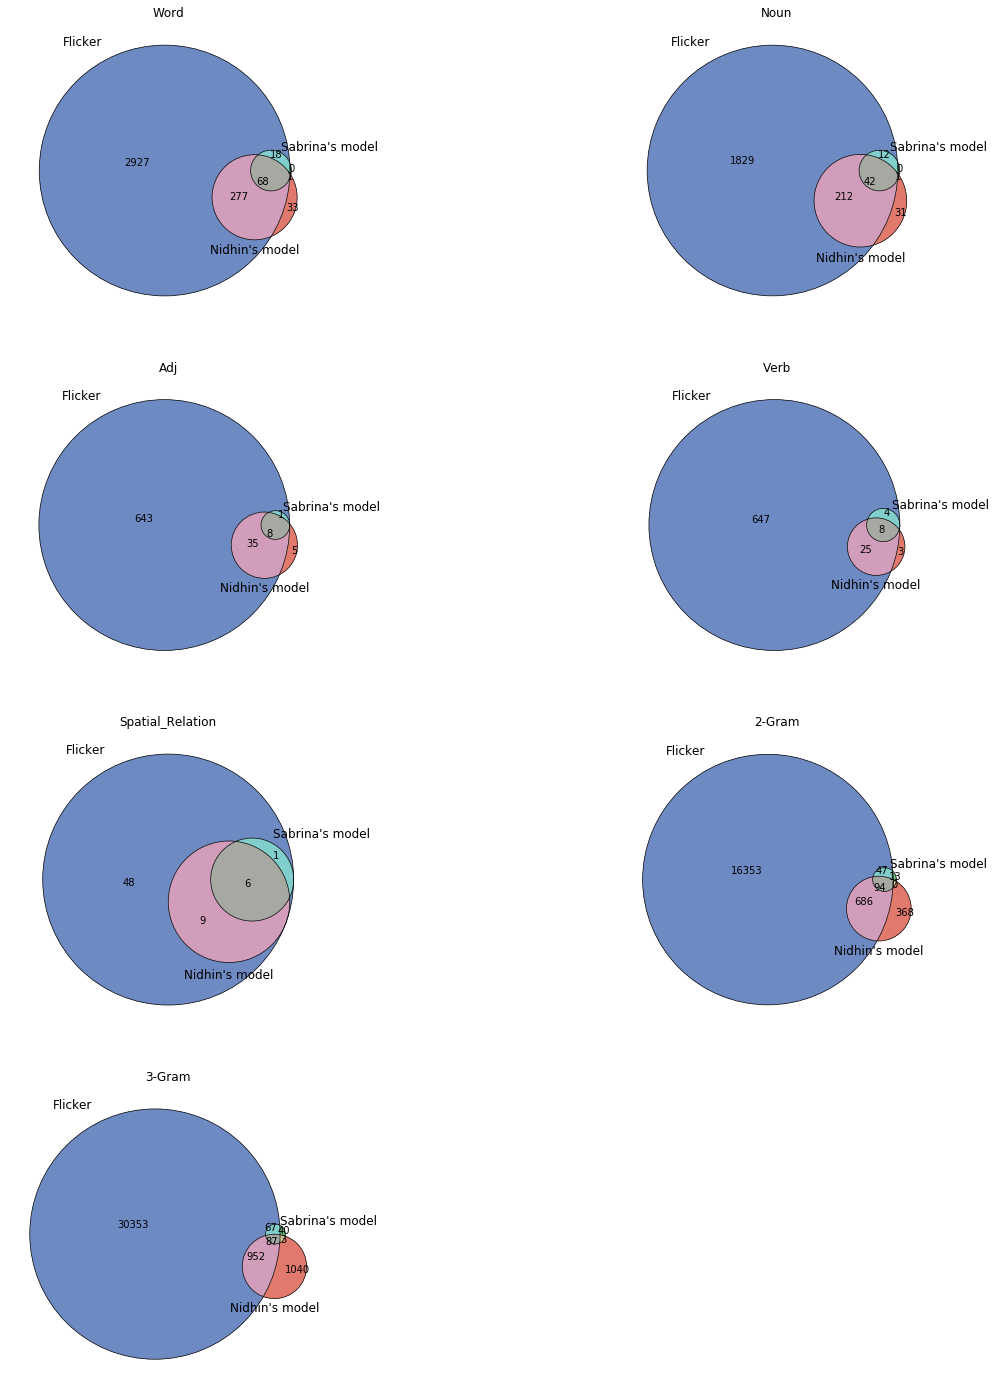

In [112]:
labels=['Flicker', "Sabrina's model", "Nidhin's model"]
types =['Word','Noun','Adj','Verb','Spatial_Relation','2-Gram','3-Gram']

plt.figure(figsize=(20,25))
for i in range(421,428):
    plt.subplot(i)
    venn3([set(r_u_fli_test[types[i-421]]),set(r_u_sab[types[i-421]]),set(r_u_nid[types[i-421]])],
      set_colors=('#3E64AF', '#3EAF5D', '#D74E3B'), 
      set_labels = ('Flicker', "Sabrina's model", "Nidhin's model" ),
      alpha=0.75)
    venn3_circles([set(r_u_fli_test[types[i-421]]),set(r_u_sab[types[i-421]]),set(r_u_nid[types[i-421]])], lw=0.7)
    plt.gca().title.set_text(types[i-421]) 
plt.show()

Because Nidhin's model is trained on COCO, which is much larger than Flicker8k, it can generate words that are not in Flicker8k. Also, number of unique words generated by Nidhin's model is higher than Sabrina's model because the same reason. In most cases, words generated by Sabrina's model ovelap Nidhin's model

#### Characterizing the performance of Nidhin's model and Sabrina's model

In this section, we want to find out why Nidhin's model and Sabrina's model have good performance on some images and not very well on other images of test dataset.

First of all, we want to split test dataset into two subset:

    - BLUE score of them > 0.5
    - BLUE score of them <= 0.5

In [130]:
def split_test_dataset(name,scores):
    cap_pos = []
    cap_neg = []
    for i in range(len(scores)):
        if scores[i]>0.5:
            cap_pos += true[i]
        else:
            cap_neg += true[i]
    r_u_nid_pos = unique_count(cap_pos,name[:3])
    r_u_nid_neg = unique_count(cap_neg,name[:3])
    r_u_nid = unique_count(pred_nid,name[:3])
    labels=['BLUE > 0.5', "BLUE <= 0.5", name+"'s model"]
    types =['Word','Noun','Adj','Verb','Spatial_Relation','2-Gram','3-Gram']

    plt.figure(figsize=(20,25))
    for i in range(421,428):
        plt.subplot(i)
        venn3([set(r_u_nid_pos[types[i-421]]),set(r_u_nid_neg[types[i-421]]),set(r_u_nid[types[i-421]])],
          set_colors=('#3E64AF', '#3EAF5D', '#D74E3B'), 
          set_labels = ('BLUE > 0.5', "BLUE <= 0.5", name+"'s model" ),
          alpha=0.75)
        venn3_circles([set(r_u_nid_pos[types[i-421]]),set(r_u_nid_neg[types[i-421]]),set(r_u_nid[types[i-421]])], lw=0.7)
        plt.gca().title.set_text(types[i-421]) 
    plt.show()

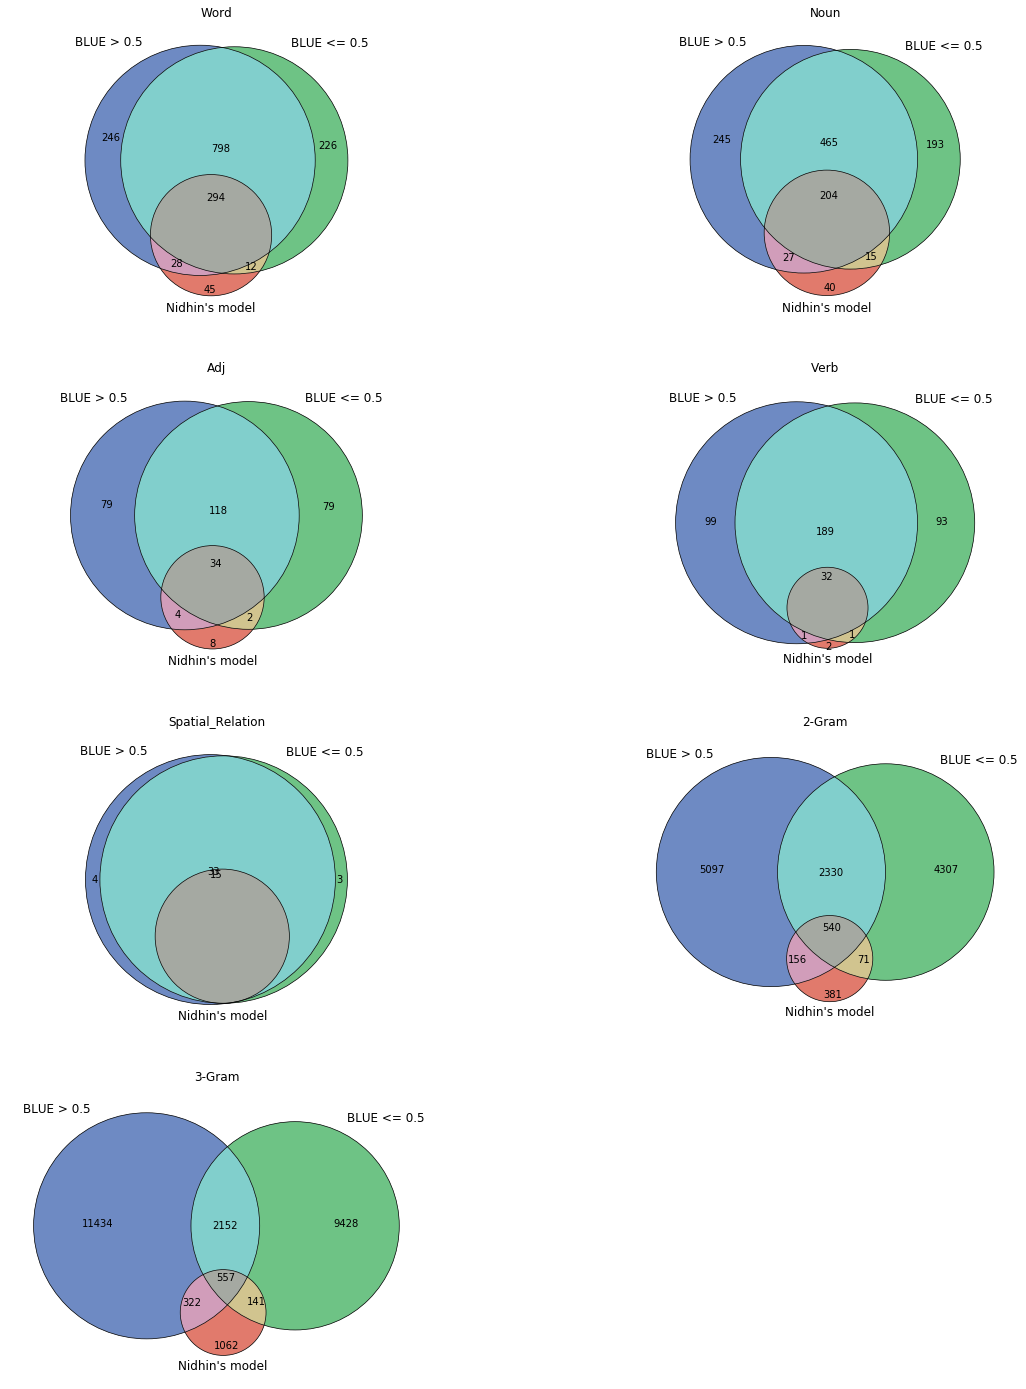

In [131]:
split_test_dataset('Nidhin',scores_nid)

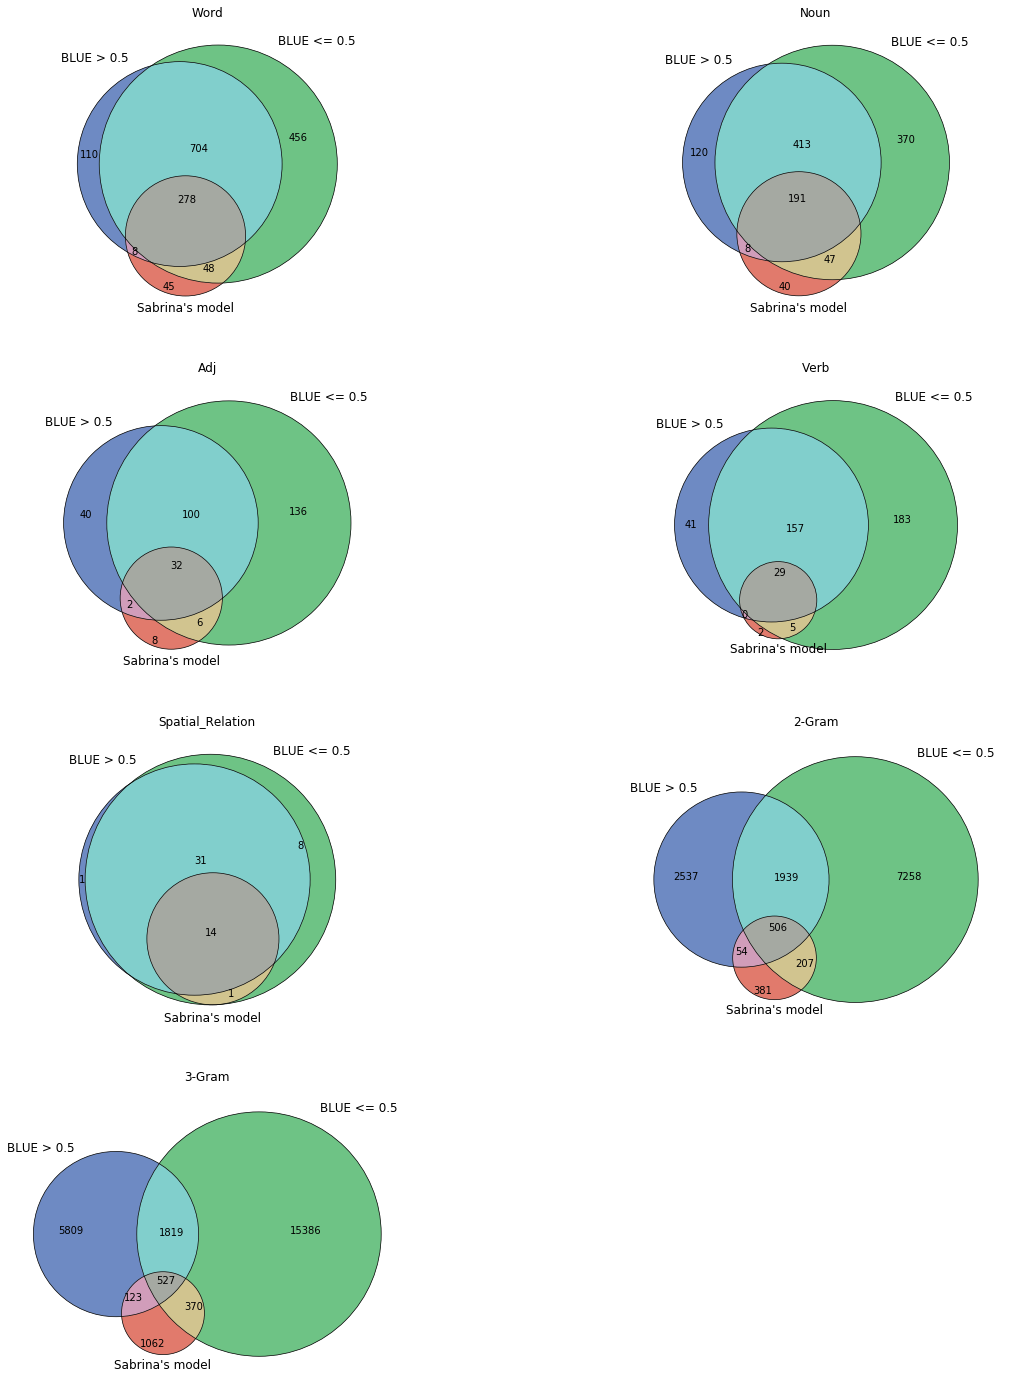

In [132]:
split_test_dataset('Sabrina',scores_sab)

In [137]:
r_sab, h_sab = count(pred_sab,'Sab')
r_nid, h_nid = count(pred_nid,'Nid')
r_fli_t, h_fli_t = count(ann_fli[35000:],'Flicker')

In [138]:
def plot_dist_pred(name):
    print('The average count of '+ name.lower() +' per caption:')
    print("Sabrina's model:", r_sab[name])
    print("Nidhin's model:", r_nid[name])
    print('Ground Truth:', r_fli_t[name])


    bins = np.linspace(0, 30, 30)
    plt.figure(figsize=(16,4))
    plt.hist(h_sab[name], bins, alpha=0.5, label="Sabrina's model", density=True)
    plt.hist(h_nid[name], bins, alpha=0.5, label="Nidhin's model", density=True)
    plt.hist(h_fli_t[name], bins, alpha=0.5, label='Ground Truth', density=True)
    plt.xlabel("Number of "+ name.lower() +" per each caption")
    plt.ylabel("Density")

    plt.legend(loc='upper right')
    plt.show()


    fig = plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    labels=["Sabrina's model", "Nidhin's model", 'Ground Truth']
    counts = [np.sum(h_sab[name]),np.sum(h_nid[name]), np.sum(h_fli_t[name])]
    plt.barh(labels, counts)
    plt.xlabel("Number of "+ name.lower())

    ax1 = fig.add_subplot(122)
    ax1.boxplot([h_sab[name],h_nid[name], h_fli_t[name]], labels=["Sabrina's model", "Nidhin's model", 'Ground Truth'],patch_artist=True,
                showmeans=False, showfliers=False,)
    plt.ylabel("Number of "+ name.lower() +" per each caption")
    plt.show()


The average count of word per caption:
Sabrina's model: 7.819431714023831
Nidhin's model: 9.32538955087076
Ground Truth: 11.815398716773602


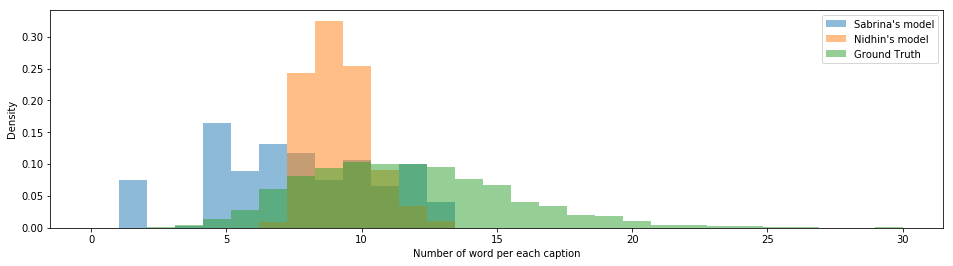

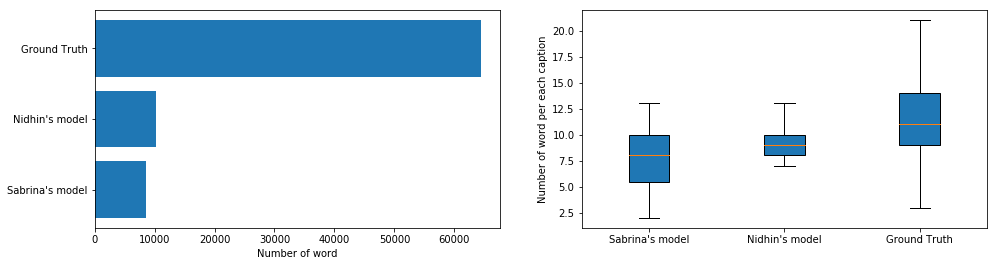

In [139]:
plot_dist_pred('Word')

The average count of noun per caption:
Sabrina's model: 2.461961503208066
Nidhin's model: 3.175068744271311
Ground Truth: 3.66141154903758


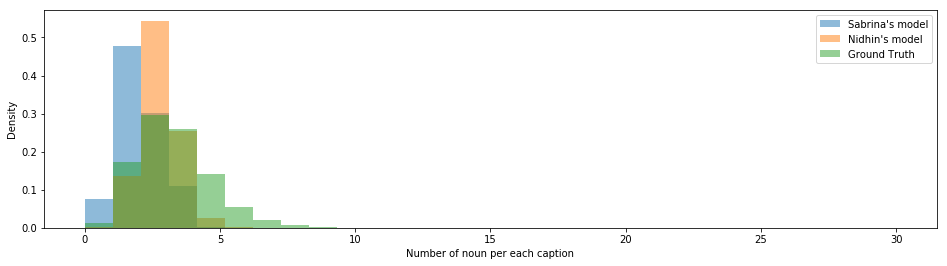

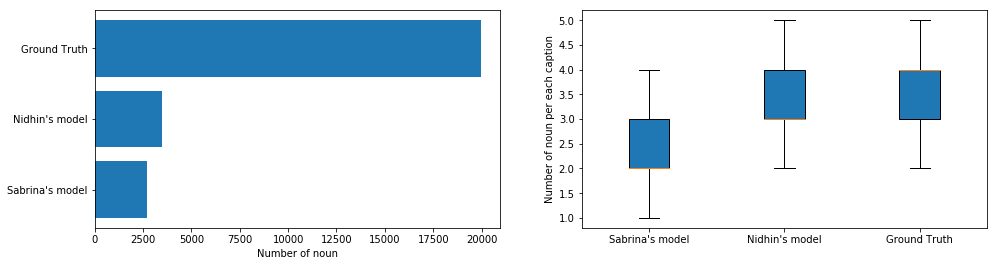

In [140]:
plot_dist_pred('Noun')

The average count of adj per caption:
Sabrina's model: 0.6260311640696609
Nidhin's model: 0.5710357470210816
Ground Truth: 1.103391384051329


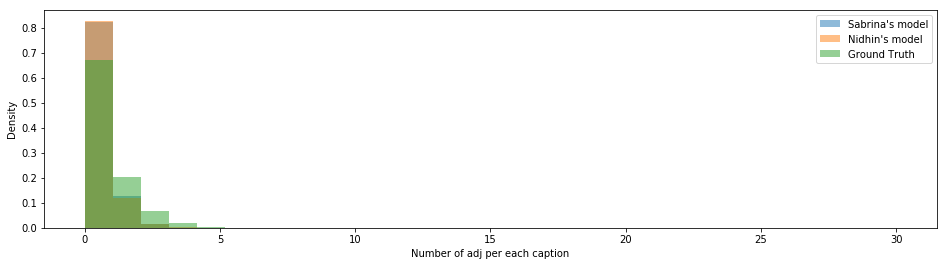

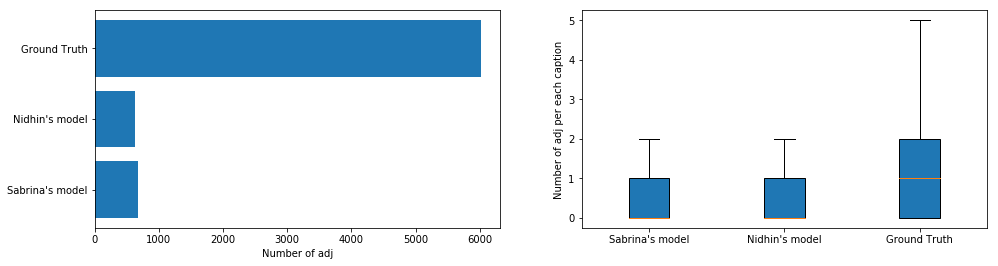

In [141]:
plot_dist_pred('Adj')

The average count of color per caption:
Sabrina's model: 0.7791017415215399
Nidhin's model: 0.38588450962419796
Ground Truth: 0.6727772685609532


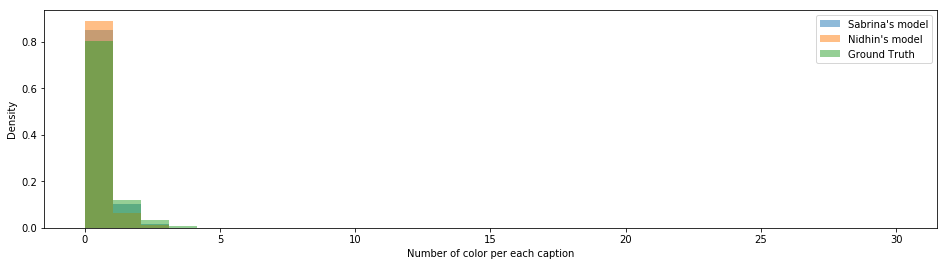

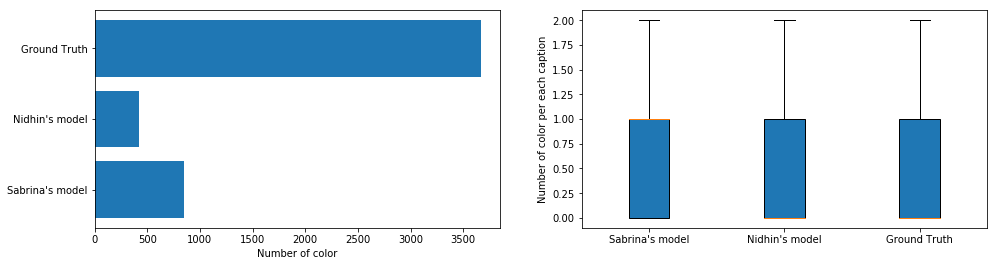

In [142]:
plot_dist_pred('Color')

The average count of verb per caption:
Sabrina's model: 1.1384051329055913
Nidhin's model: 1.0357470210815765
Ground Truth: 1.2042163153070577


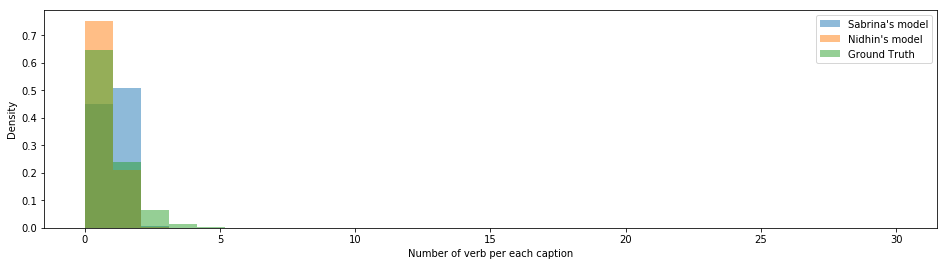

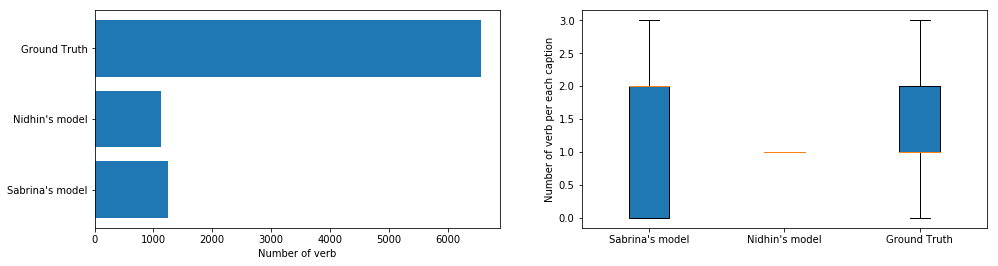

In [143]:
plot_dist_pred('Verb')

The average count of spatial_relation per caption:
Sabrina's model: 0.9807516040329972
Nidhin's model: 1.5499541704857929
Ground Truth: 1.6183318056828597


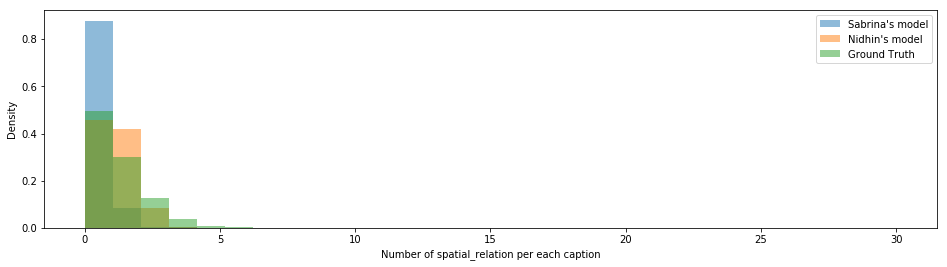

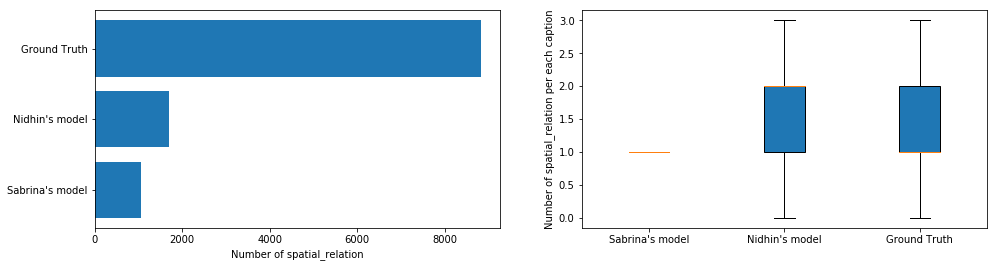

In [144]:
plot_dist_pred('Spatial_Relation')

Interestingly, Nidhin's model can produce similar word distribution to COCO distribution, and probably because it is trained with more data, it generated more words than Sabrina's model. Sabrina's model can generate more "color" in captions likely because Flicker8k has more "color" than COCO.

### Summary

We summarize this notebook in two sections:


##### EDA

In each section, we wrote some conclusions. To sum up, captions typically consist of roughly 11-13 words that involve 3-4 objects (i.e., nouns) in conjunction with 1-2 descriptors (i.e., adjectives), 1 action (i.e., verb), and 1-2 relationships (i.e., spatial relationship words). The interval of the length of each caption in VizWiz and Flicker is higher than MSCOCO. VizWiz has a higher average noun, adjective, spatial relation, and color per caption, which makes producing captions for images of this dataset harder than other datasets.

There are a lot of unique nouns in each dataset. Despite the fact that the vision datasets have only a thousand categories, it shows us to have better image captioning models we need more complex datasets. Although VizWiz has much fewer captions than COCO, it seems the diversity of words of VizWiz is higher than COCO because VizWiz has approximately similar unique nouns and adjectives to COCO.

Differences between VizWiz and COCO are further than the differences between Flicker and COCO. It means that VizWiz has more share of nouns and adjectives that have not been seen in COCO rather than Flicker. So, it seems a model that is trained on COCO probably does well on Flicker, not VizWiz (Our experiment proved it because Nidhin's model does better than Sabrina's model). 

The most common nouns in Flicker are "Man", "Girl", "Women", etc, which are different from the most common nouns in VizWiz and COCO. Also, there is more similarity between adjectives in VizWiz and COCO than Flicker and other datasets. "is sitting" and "is holding" are verbs that can be seen mostly in both of VizWiz and COCO.

One of the other differences is pictures in VizWiz are mostly indoor, but images in Flicker and COCO are outdoor, which can be an important issue. Another important point is COCO approximately can cover all scenes in VizWiz and Flicker, though it may have some biases to outdoor scenes. The overlap between VizWiz and Flicker is not much as the overlap between COCO and other datasets.

Objects in COCO have good overlap with other datasets. Especially, Flicker has a fine overlap with COCO. Again, we can infer that VizWiz has more diverse captions because although it has fewer captions than COCO, it contains enough ImageNet objects.


##### Evaluation

The BLUE score of Nidhin's model is **0.53** and Sabrina's model is **0.40**. 

Because Nidhin's model is trained on COCO, which is much larger than Flicker8k, it shows better performance than Sabrina's model and generates words that are not in Flicker8k. Also, because of the same reason, the number of unique words generated by Nidhin's model is higher than Sabrina's model. Captions generated by both models are similar to the dataset that are trained on. Nidhin's model generates more words per caption. On the other hand, Sabrina's model can generate more "color" in captions likely because Flicker8k has more "color" than COCO.

### Refrences

    - https://cocodataset.org/
    - https://vizwiz.org/tasks-and-datasets/image-captioning/
    - https://www.kaggle.com/jainamshah17/flicker8k-image-captioning